In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from lataq.models import EMBEDCVAE
from lataq_reproduce.exp_dict import EXPERIMENT_INFO
from sklearn.metrics import classification_report

%load_ext autoreload
%autoreload 2

In [3]:
plt.rcParams['figure.dpi'] = 600

# Workflow on pancreas data

In [3]:
adata = sc.read('./../data/pancreas.h5ad')

In [4]:
exp_info = EXPERIMENT_INFO['pancreas']

In [5]:
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.neighbors(adata_pp)
sc.pp.pca(adata_pp)
sc.tl.umap(adata_pp)

         Falling back to preprocessing with `sc.pp.pca` and default params.


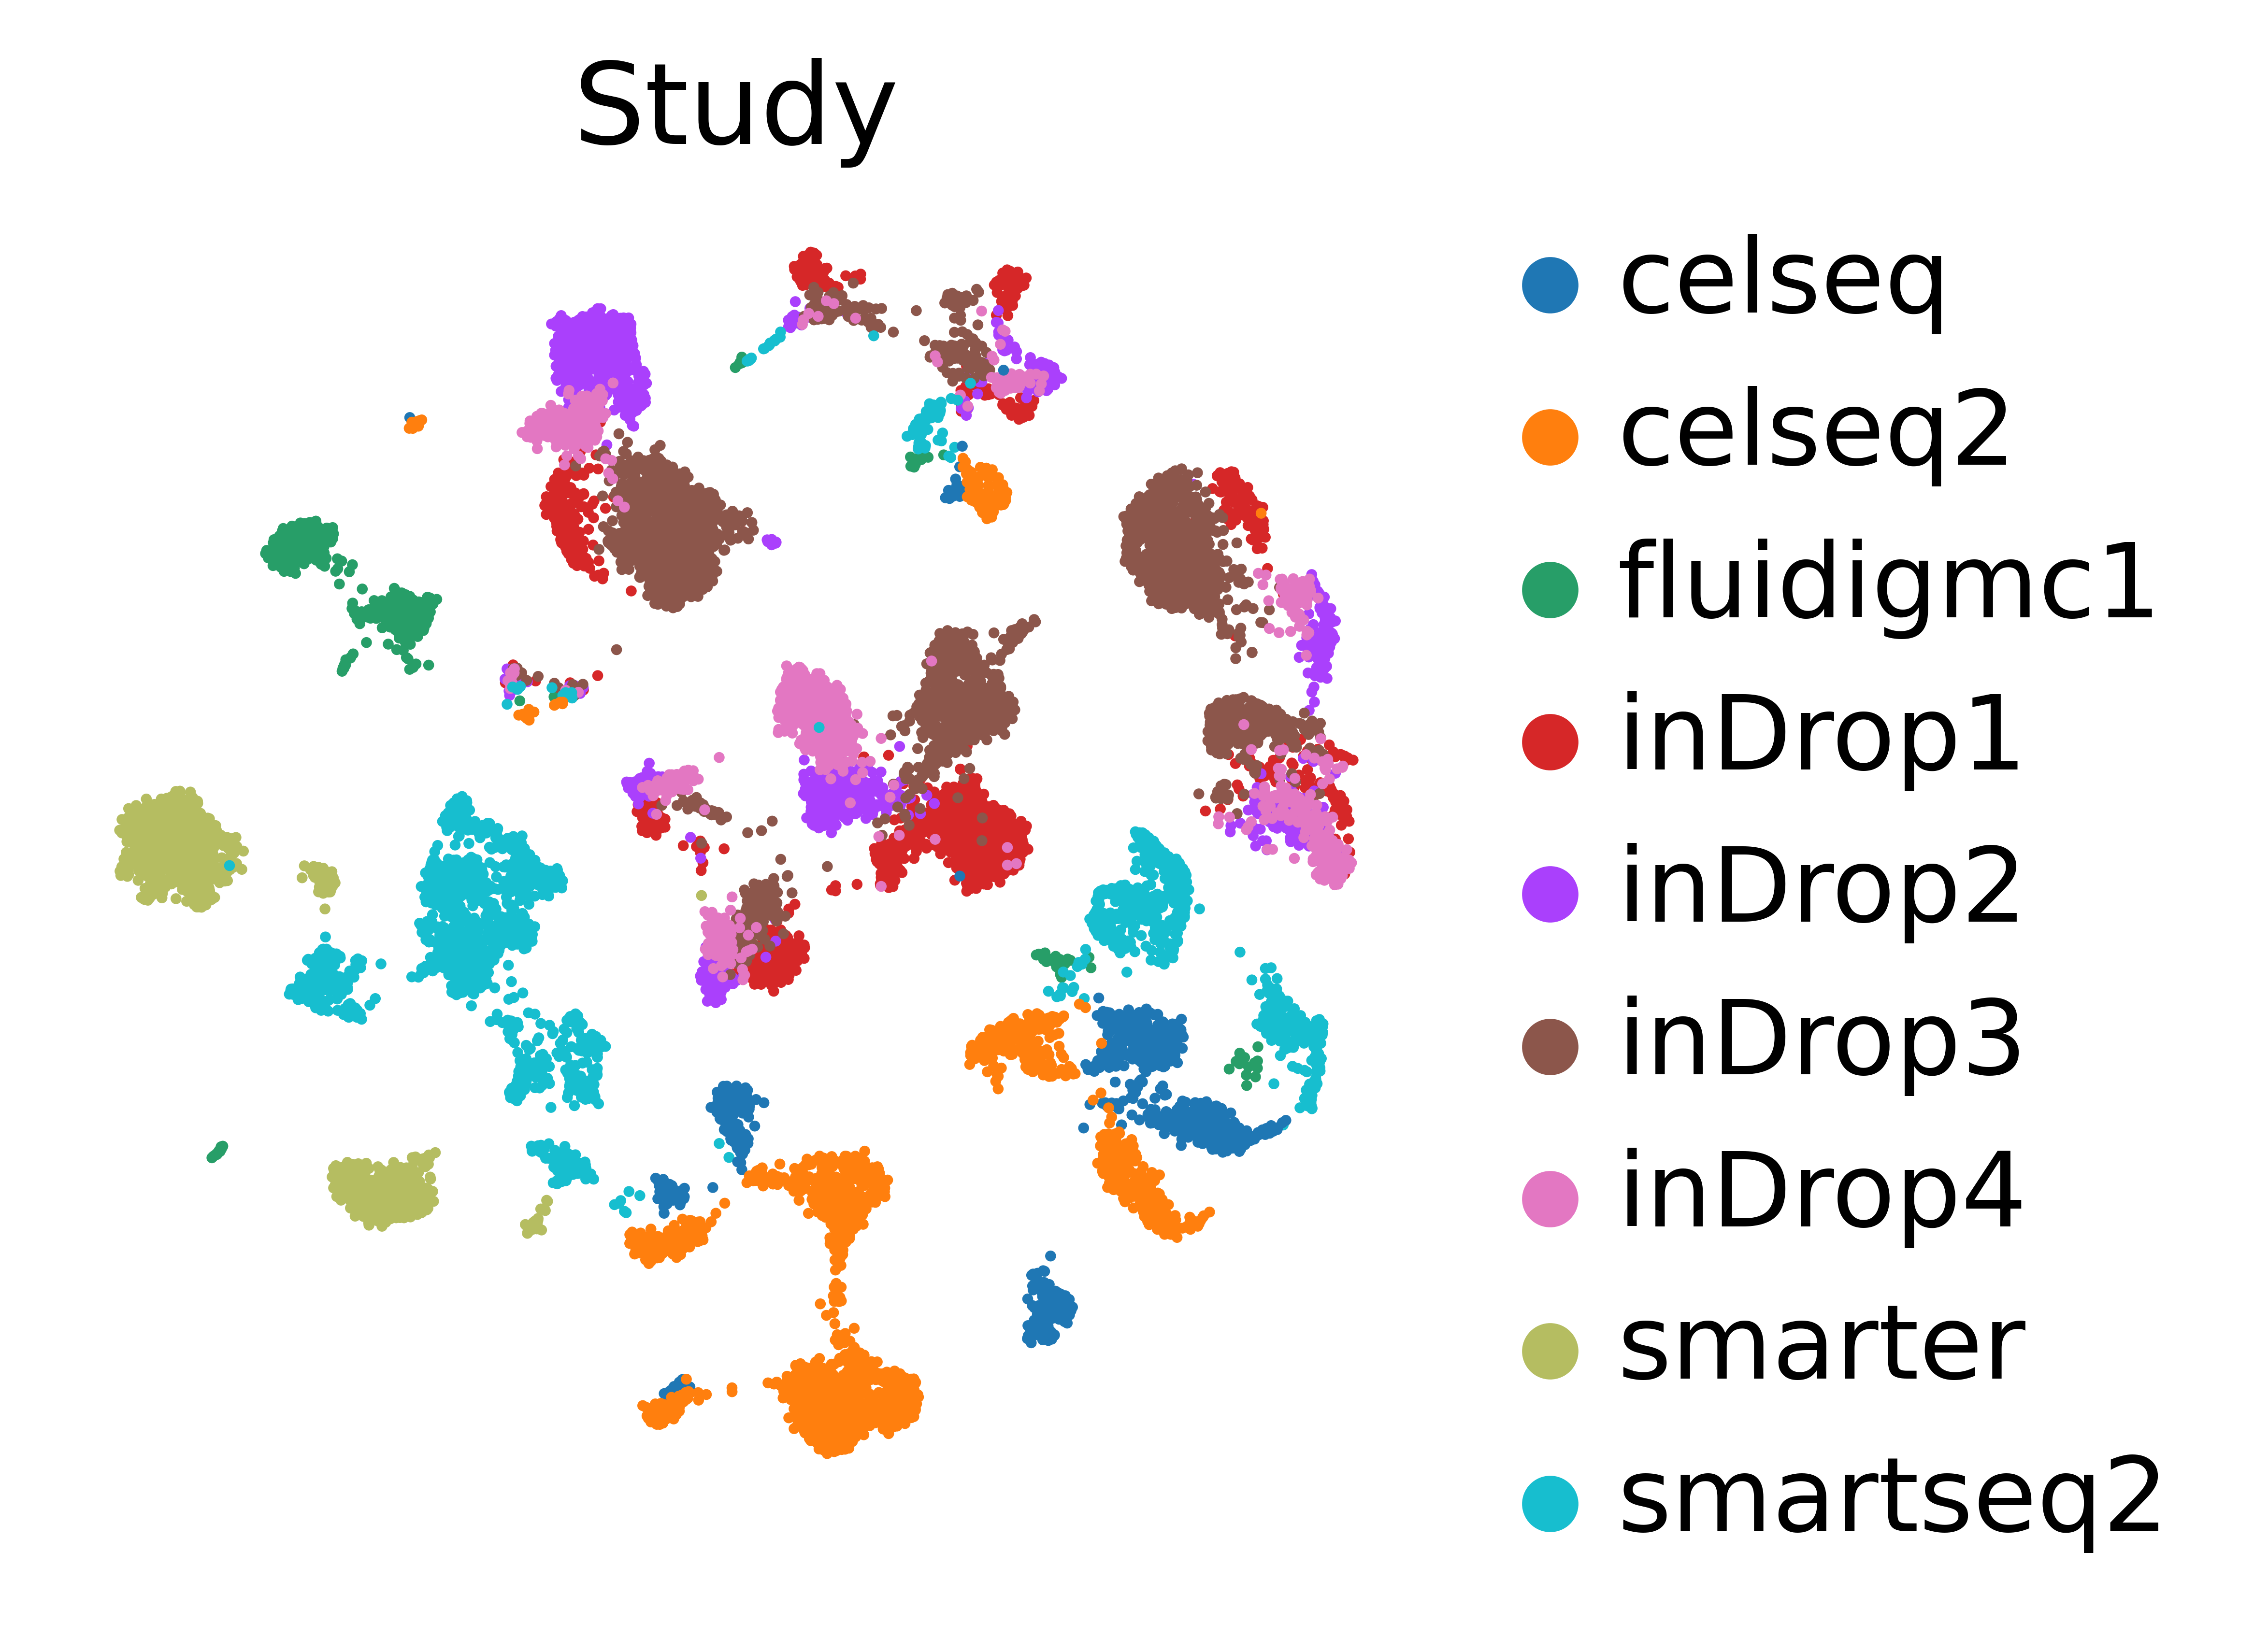

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sc.pl.umap(
    adata_pp,
    color=exp_info['condition_key'],
    show=False,
    frameon=False,
    ax=ax
)
#ax.legend().set_title('Study')
ax.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('Study')
fig.savefig('figure2/umap_original_study.png', dpi=500, bbox_inches='tight')

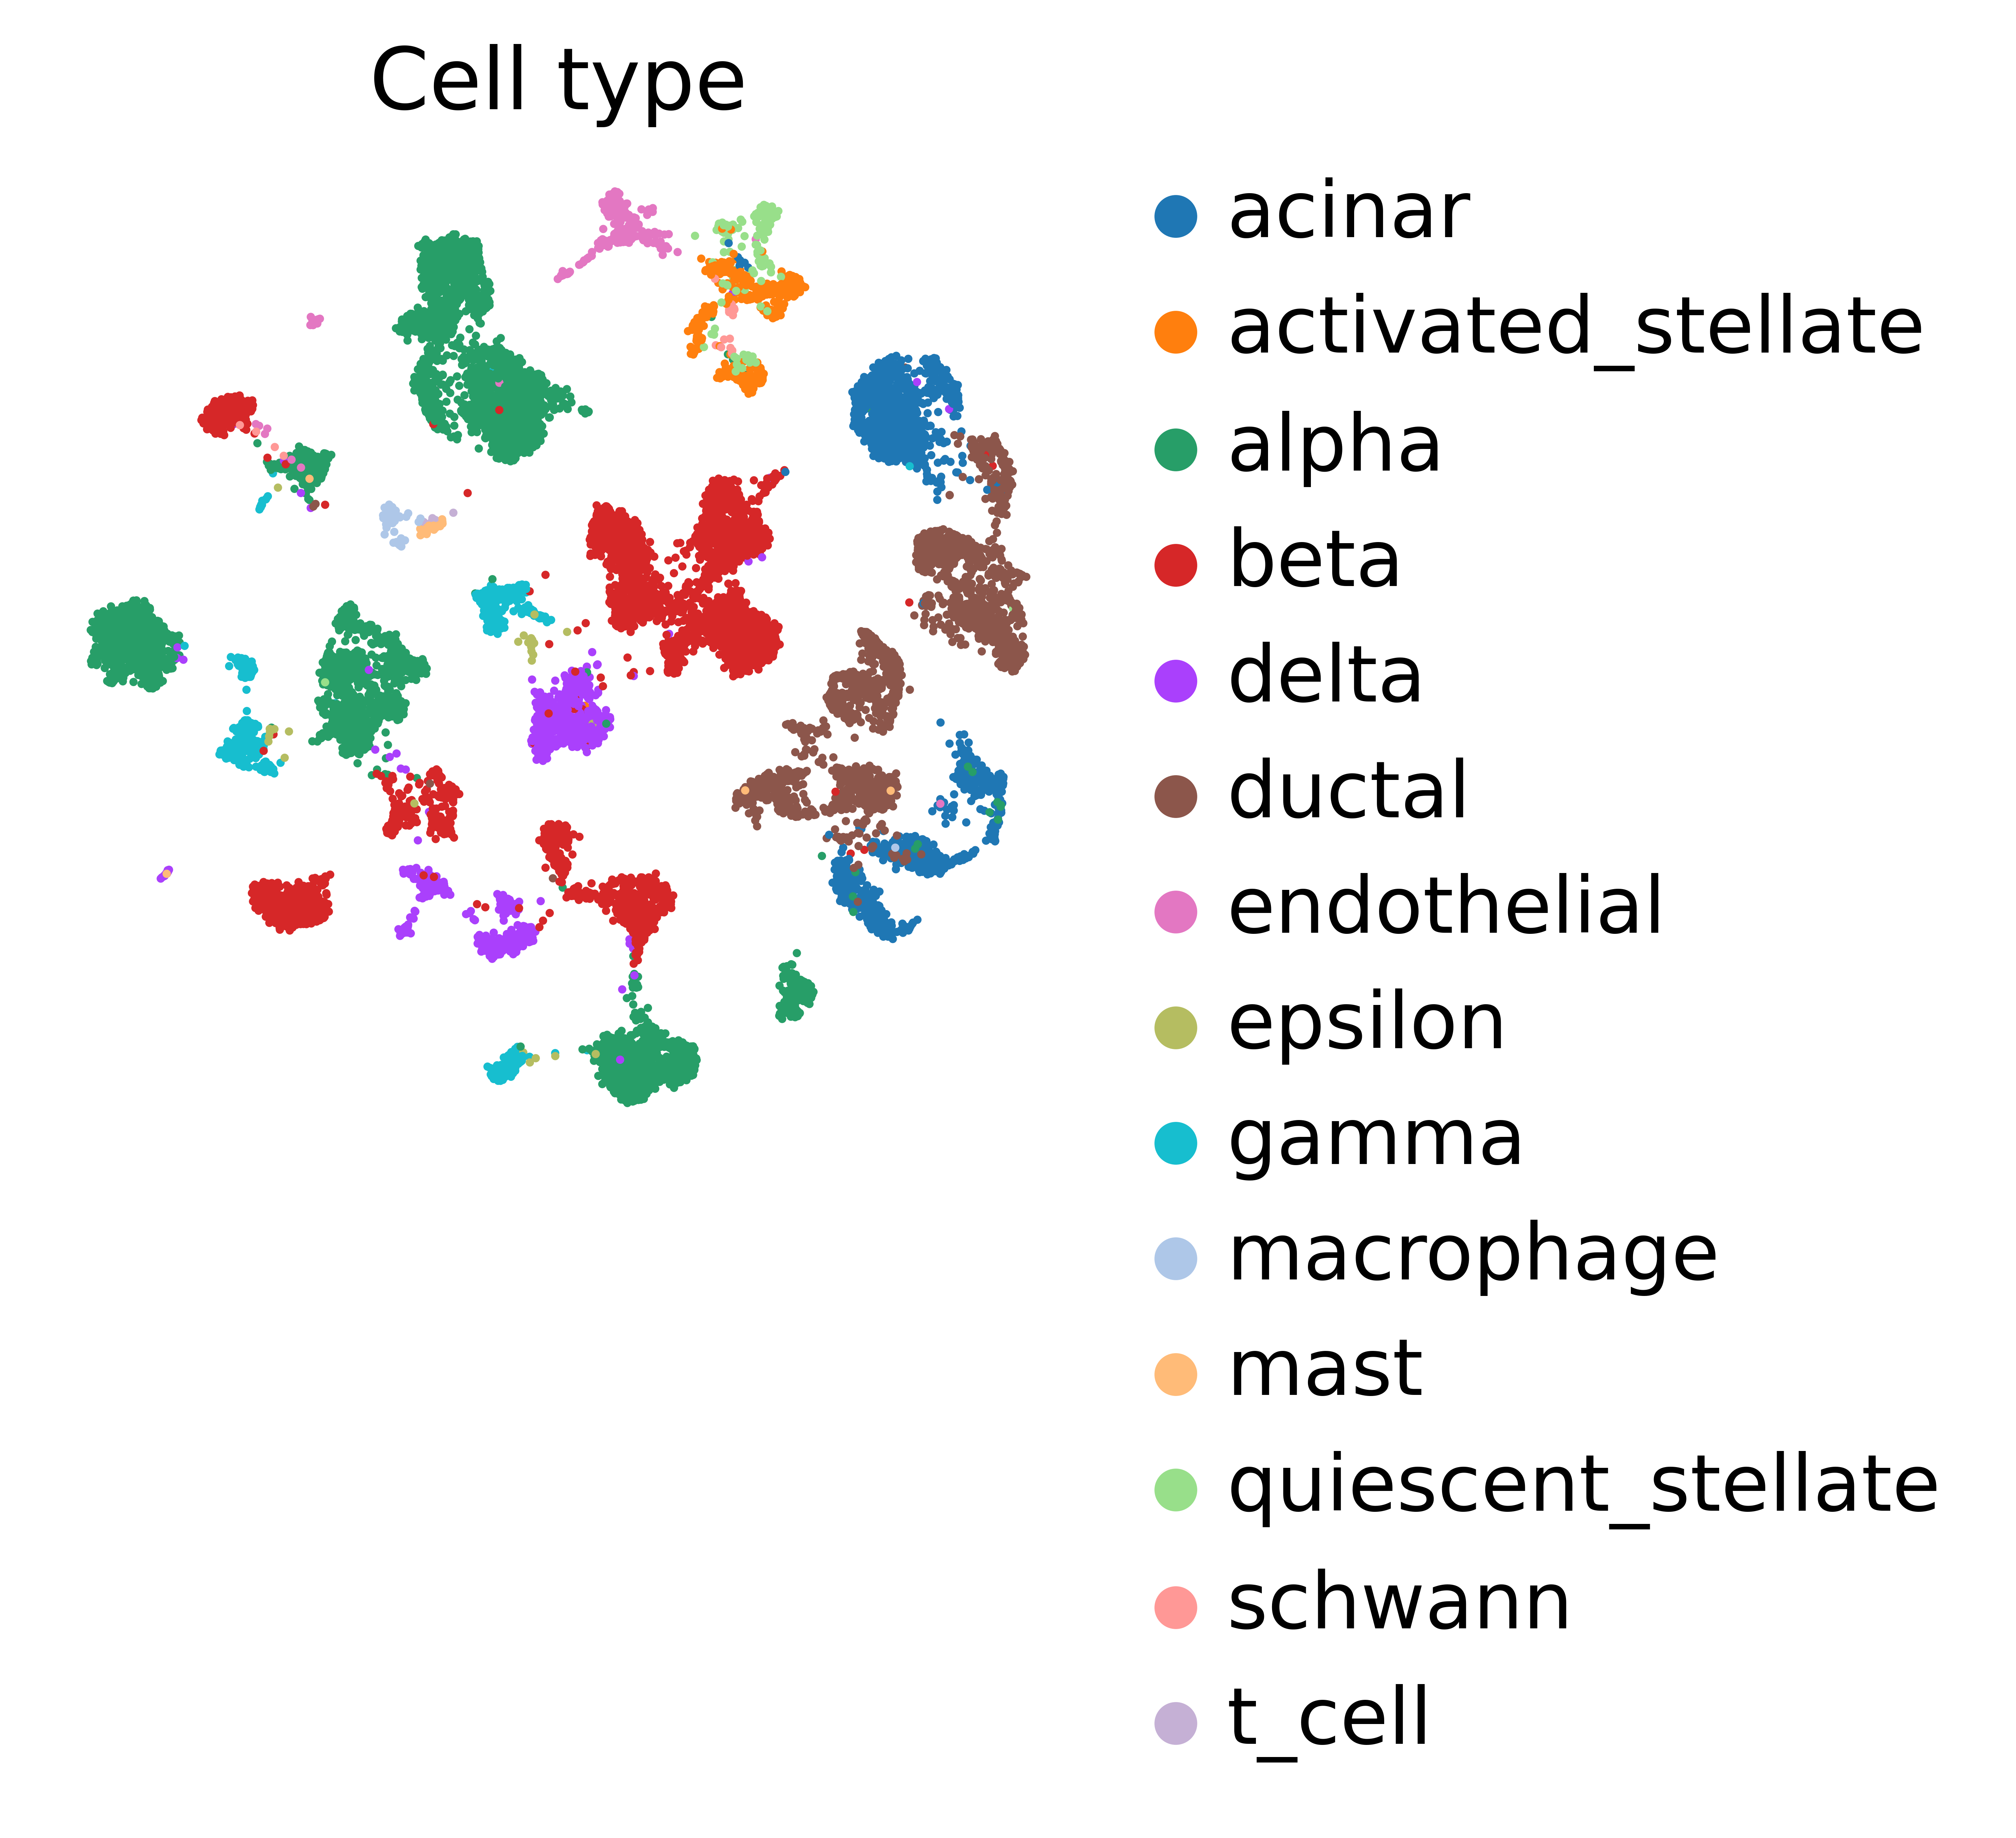

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sc.pl.umap(
    adata_pp,
    color=exp_info['cell_type_key'],
    show=False,
    frameon=False,
    ax=ax
)
ax.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('Cell type')
fig.savefig('figure2/umap_original_celltype.png', dpi=500, bbox_inches='tight')

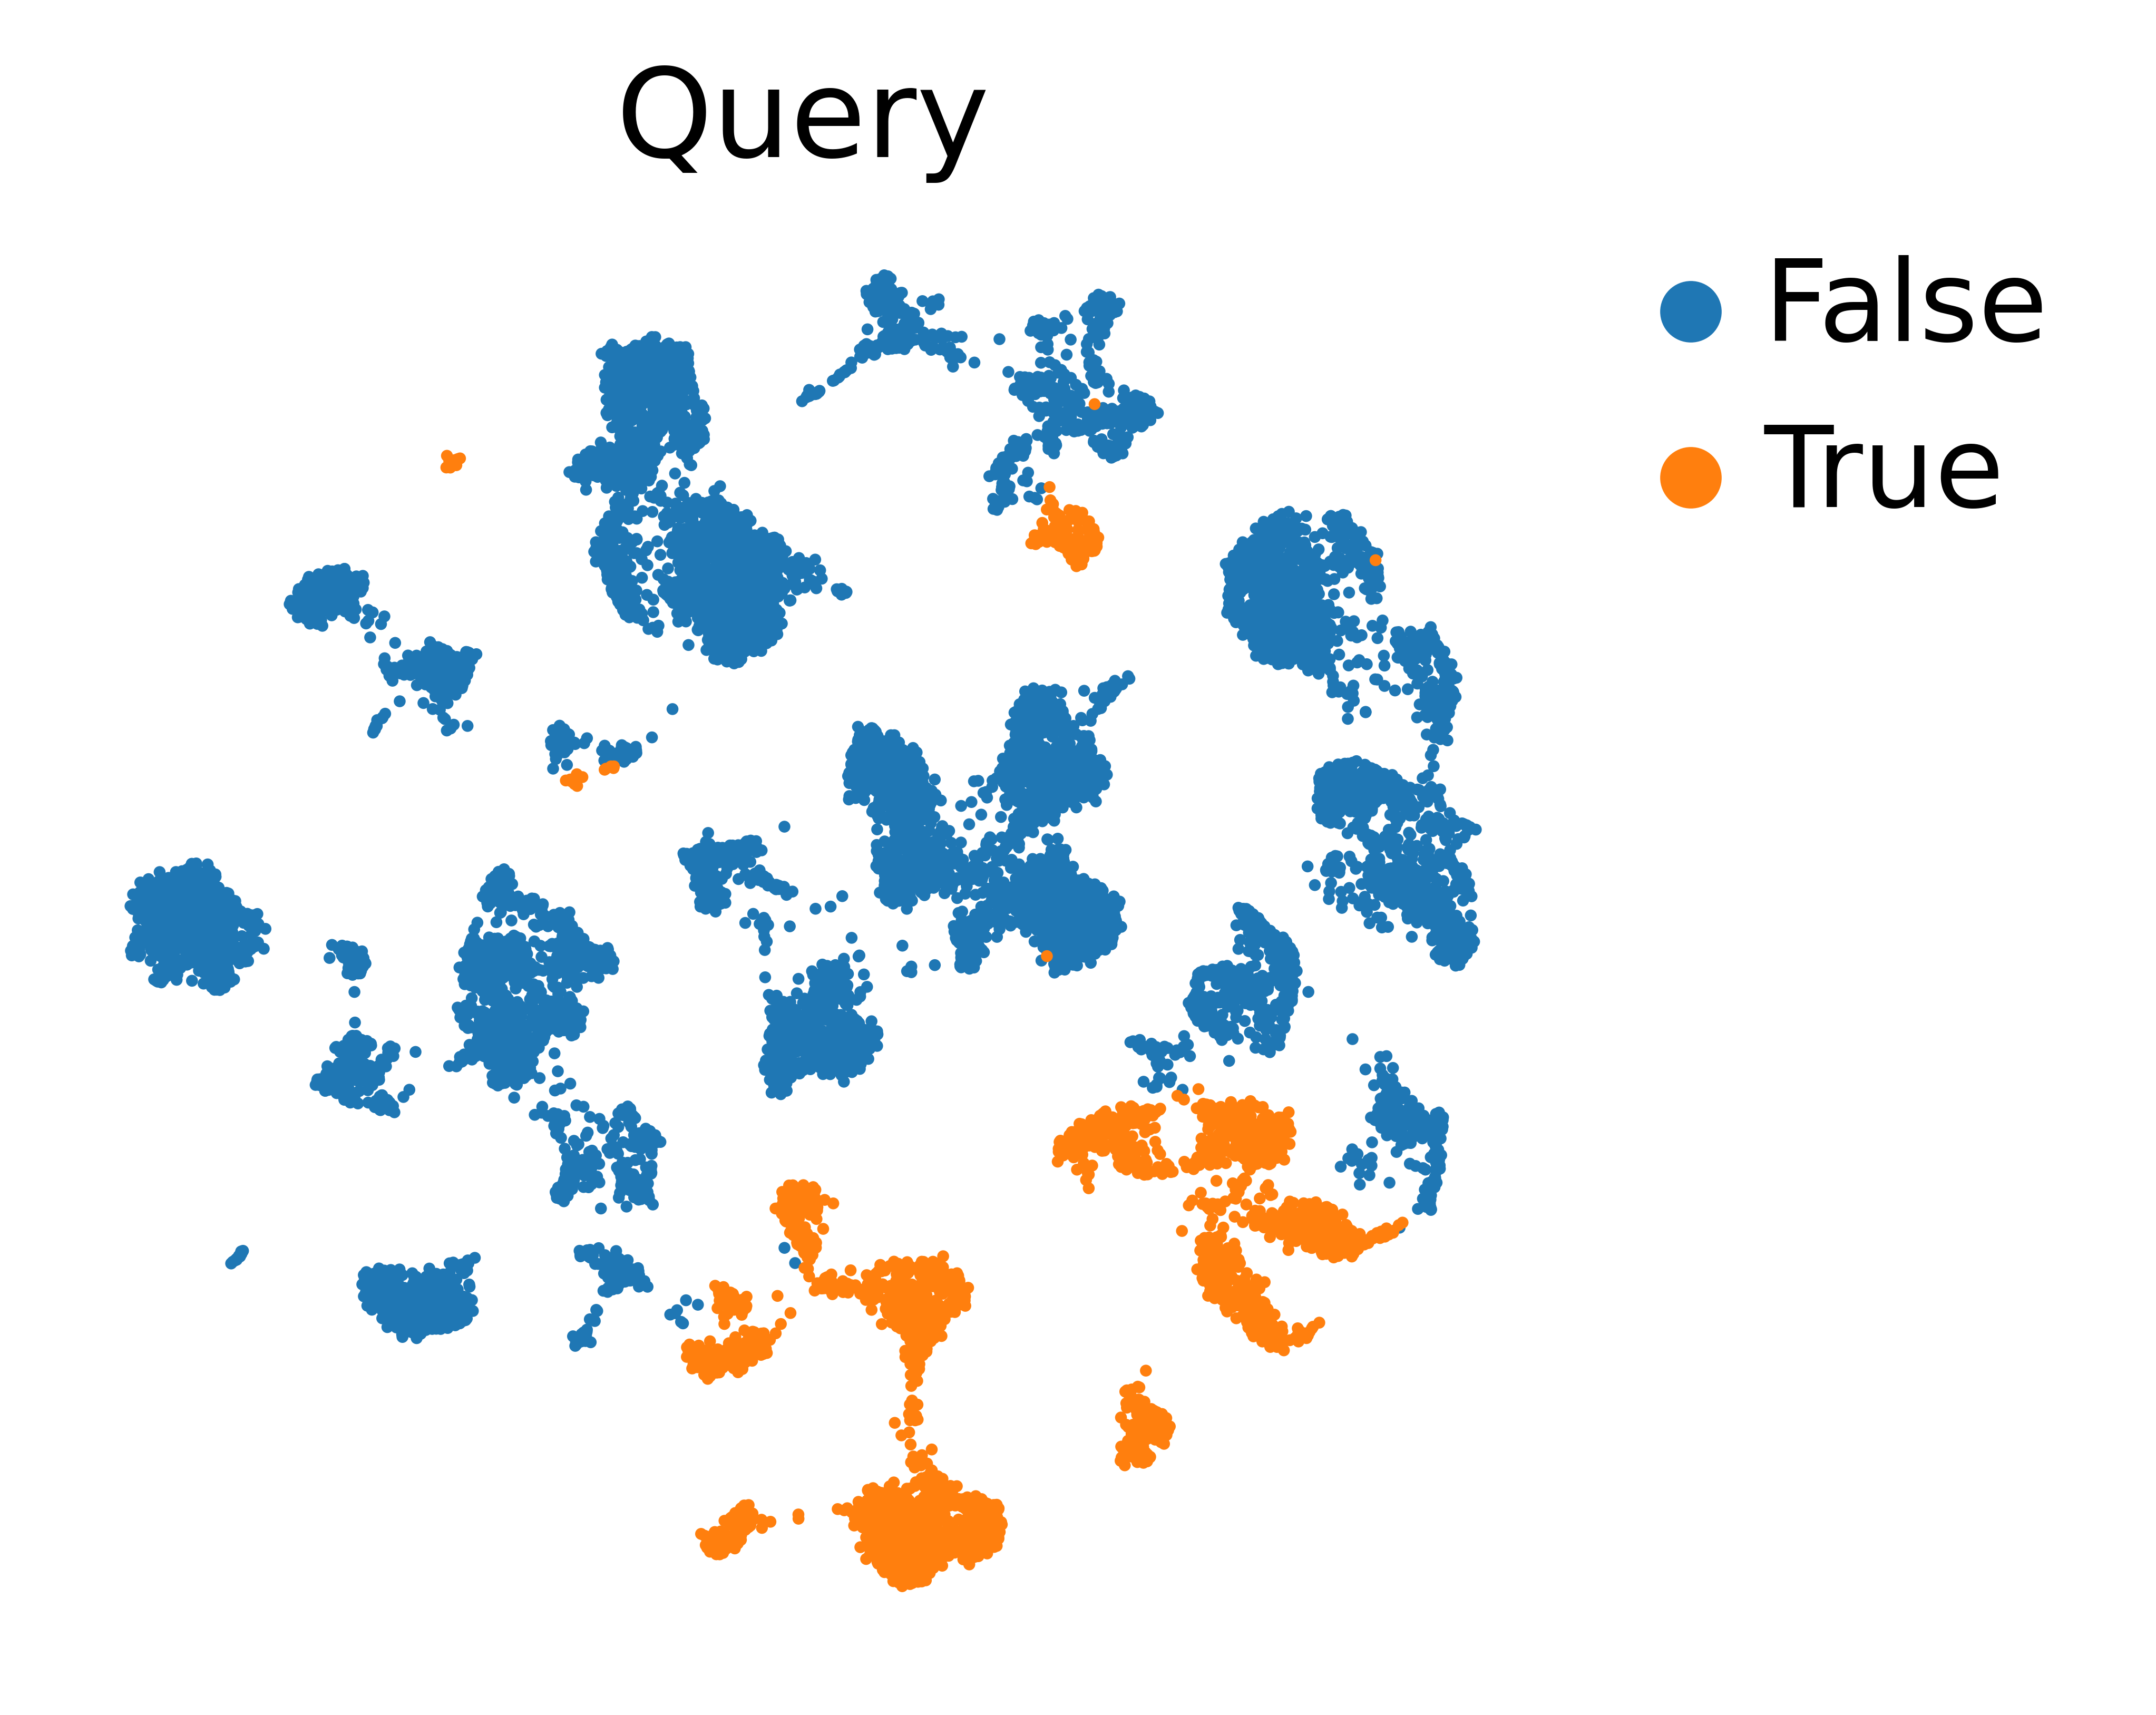

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
adata_pp.obs['query'] = (adata_pp.obs[exp_info['condition_key']].isin(exp_info['query'])).astype('category')
sc.pl.umap(
    adata_pp,
    color='query',
    show=False,
    frameon=False,
    ax=ax
)
ax.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('Query')
fig.savefig('figure2/umap_original_query.png', dpi=500, bbox_inches='tight')

In [9]:
lataq = EMBEDCVAE.load('./../notebooks/pancreas_wquery', adata)

AnnData object with n_obs × n_vars = 16382 × 4000
    obs: 'study', 'cell_type', 'pred_label', 'pred_score'
    obsm: 'X_seurat', 'X_symphony'
Embedding dictionary:
 	Num conditions: 9
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 25
Decoder Architecture:
	First Layer in, out and cond:  25 128 10
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 4000 



In [10]:
latent_adata = sc.AnnData(
    X = lataq.get_latent(
        x=adata.X,
        c=adata.obs[exp_info['condition_key']]
    ),
    obs=adata.obs,
)

In [11]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

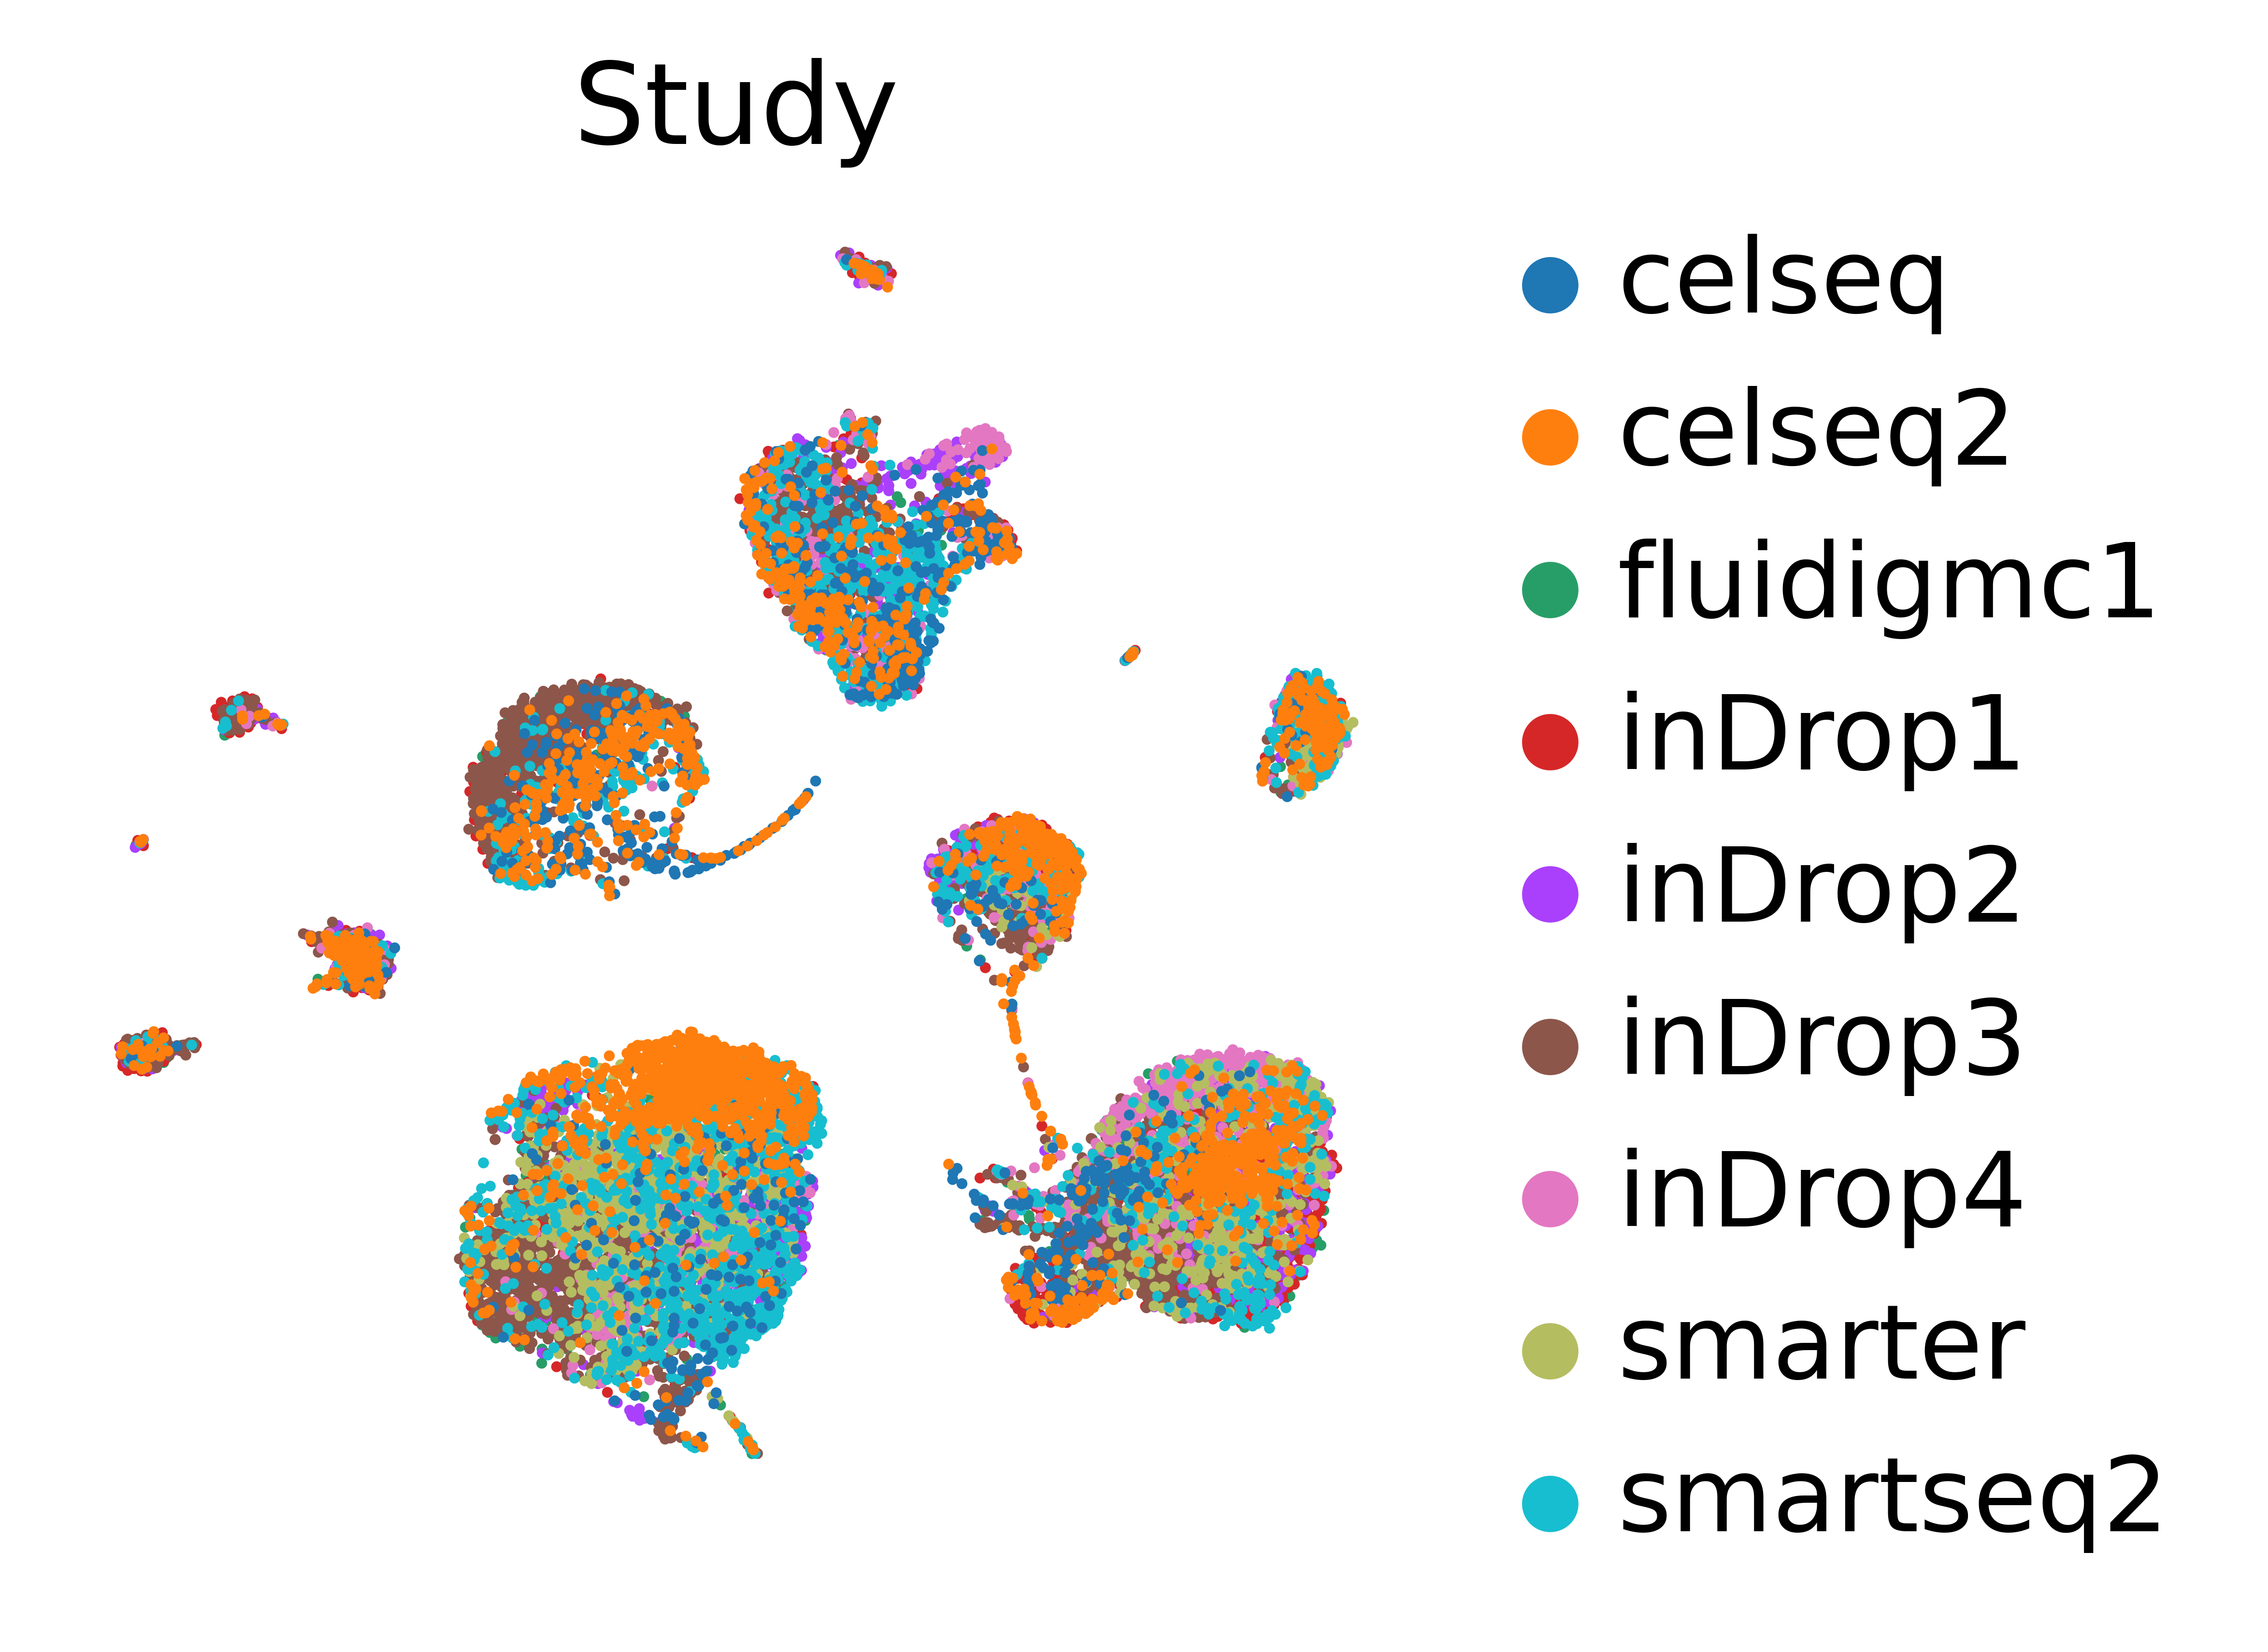

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sc.pl.umap(
    latent_adata,
    color=exp_info['condition_key'],
    show=False,
    frameon=False,
    ax=ax
)
ax.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('Study')
fig.savefig('figure2/umap_wquery_study.png', dpi=500, bbox_inches='tight')

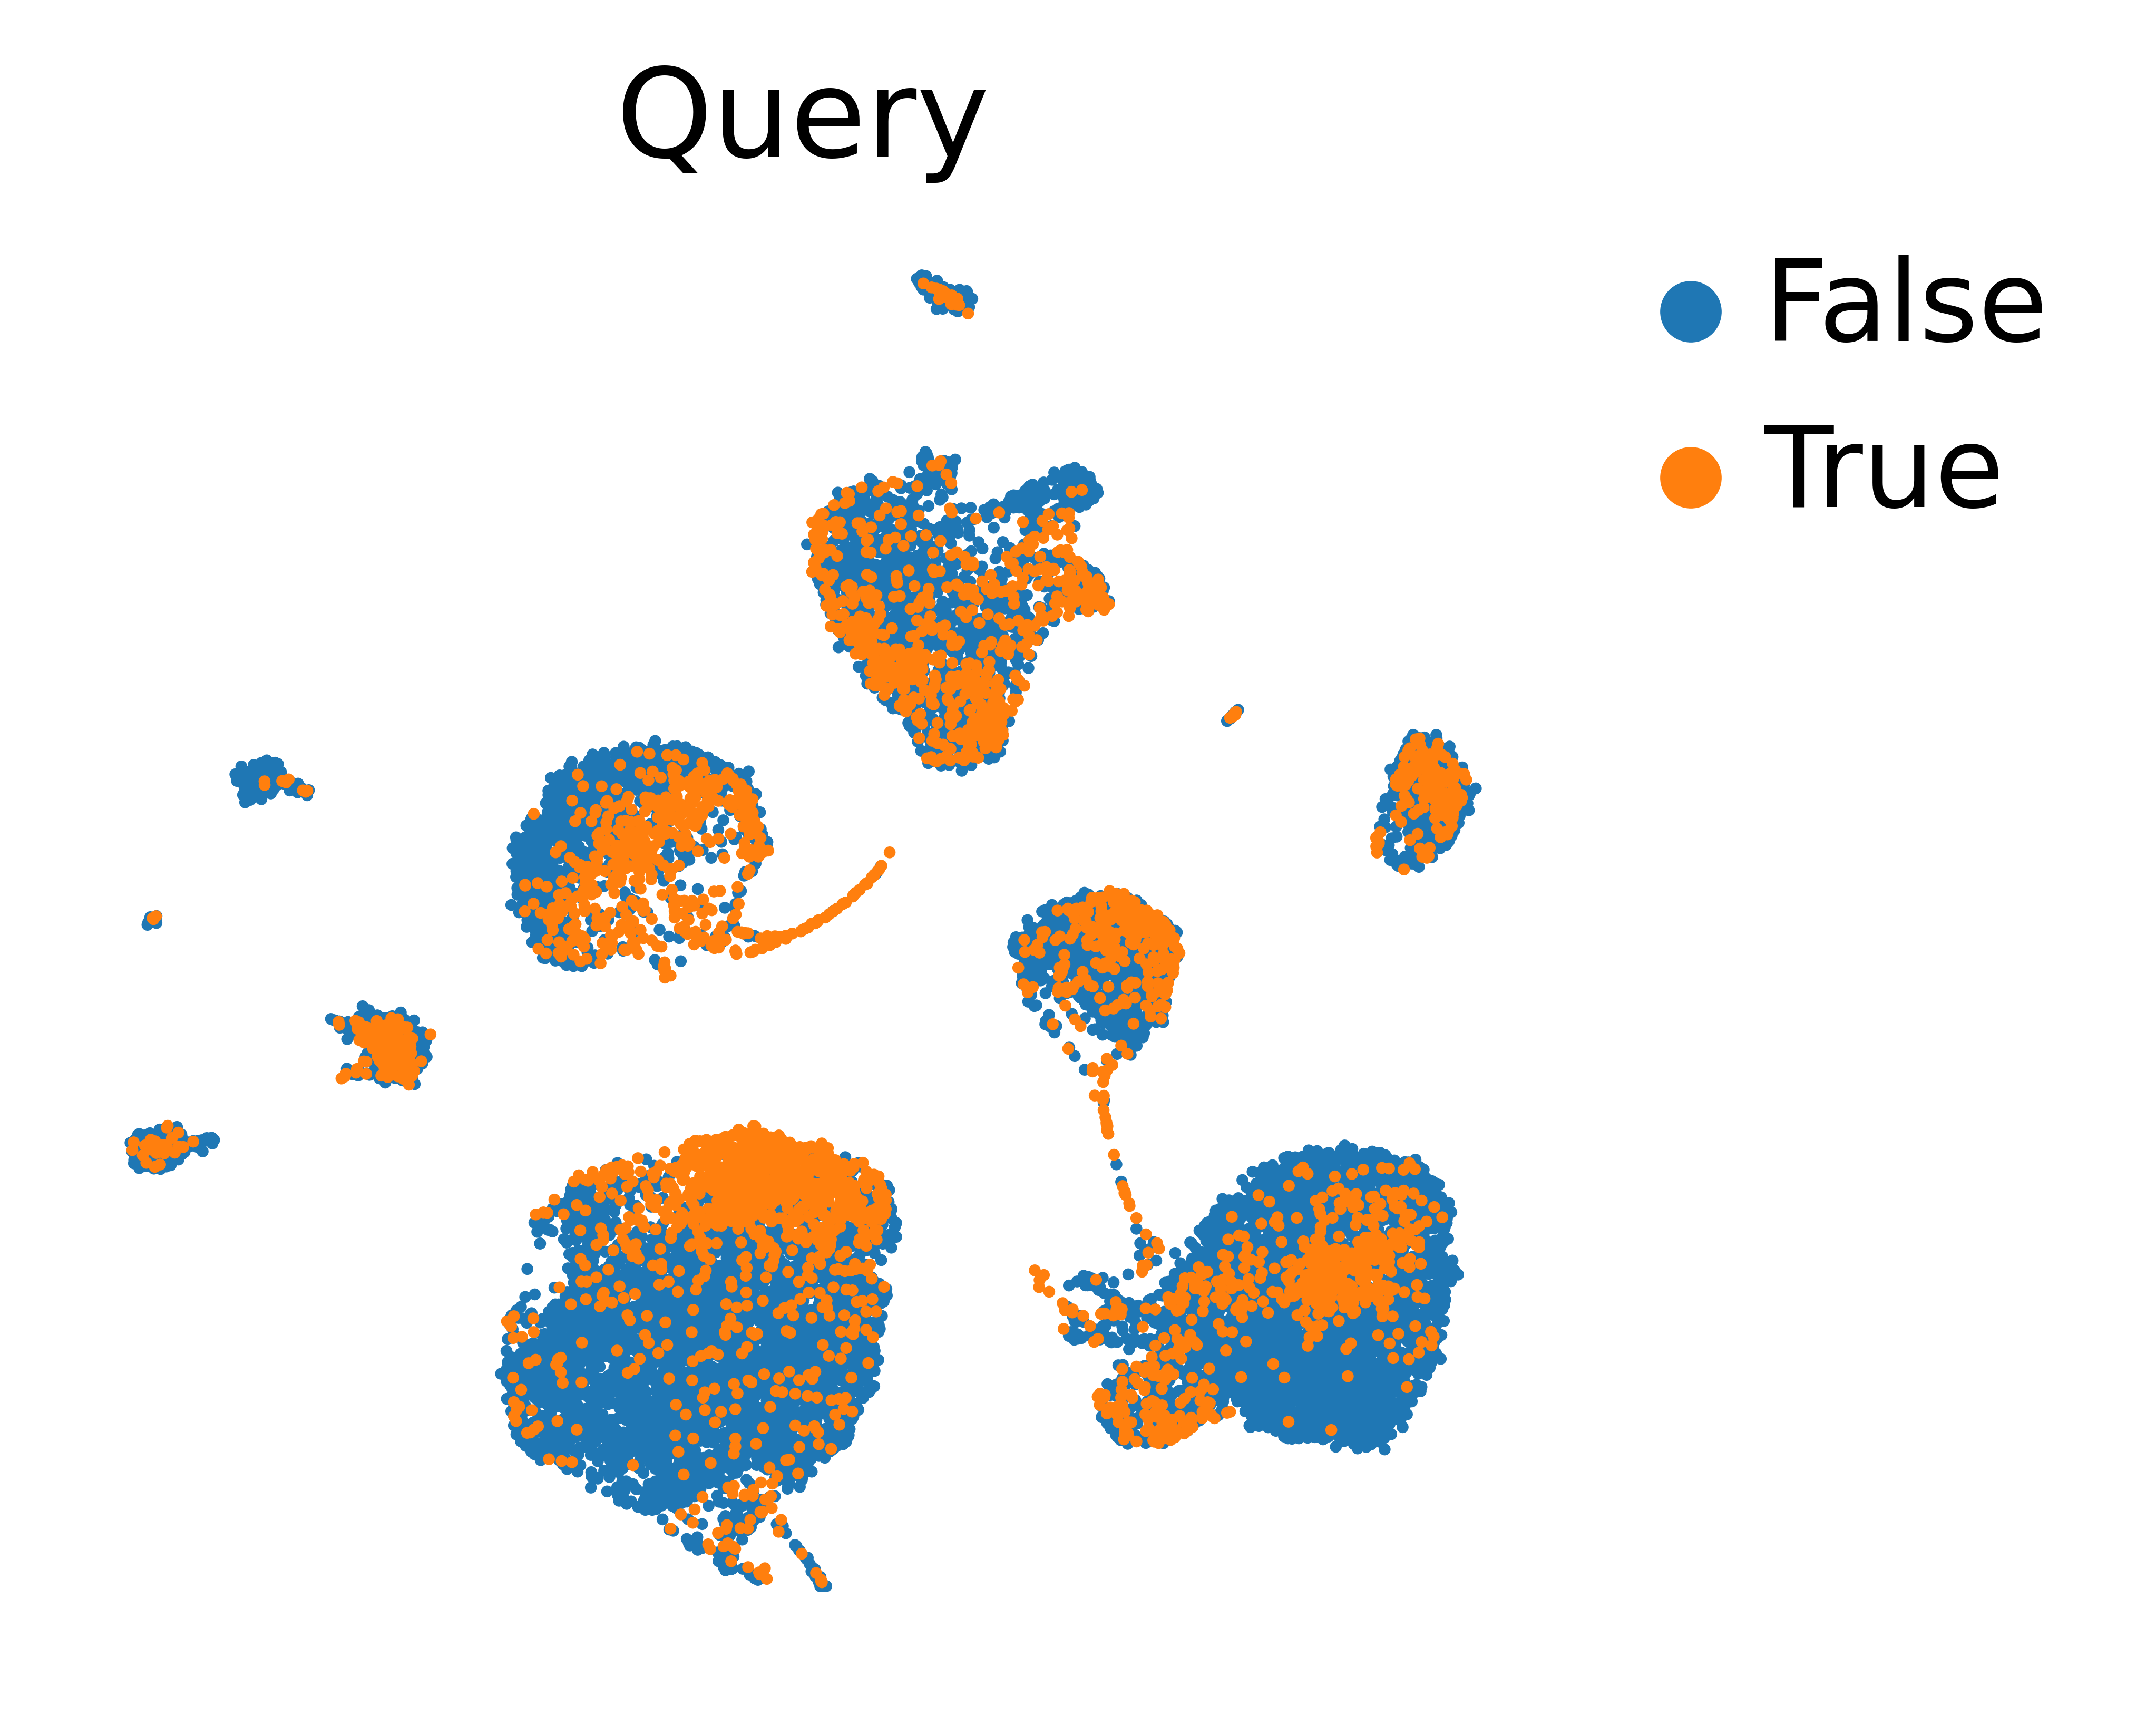

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
latent_adata.obs['query'] = (latent_adata.obs[exp_info['condition_key']].isin(exp_info['query'])).astype('category')
sc.pl.umap(
    latent_adata,
    color='query',
    show=False,
    frameon=False,
    ax=ax
)
ax.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('Query')
fig.savefig('figure2/umap_wquery_query.png', dpi=500, bbox_inches='tight')

In [14]:
results_dict = lataq.classify(
    adata.X, 
    adata.obs[exp_info['condition_key']], 
    metric='dist',
)
cell_type_key = exp_info['cell_type_key']
for i in range(len(cell_type_key)):
    preds = results_dict[cell_type_key[i]]['preds']
    probs = results_dict[cell_type_key[i]]['probs']

latent_adata.obs['cell_type_pred'] = preds
latent_adata.obs['cell_type_probs'] = probs

... storing 'cell_type_pred' as categorical


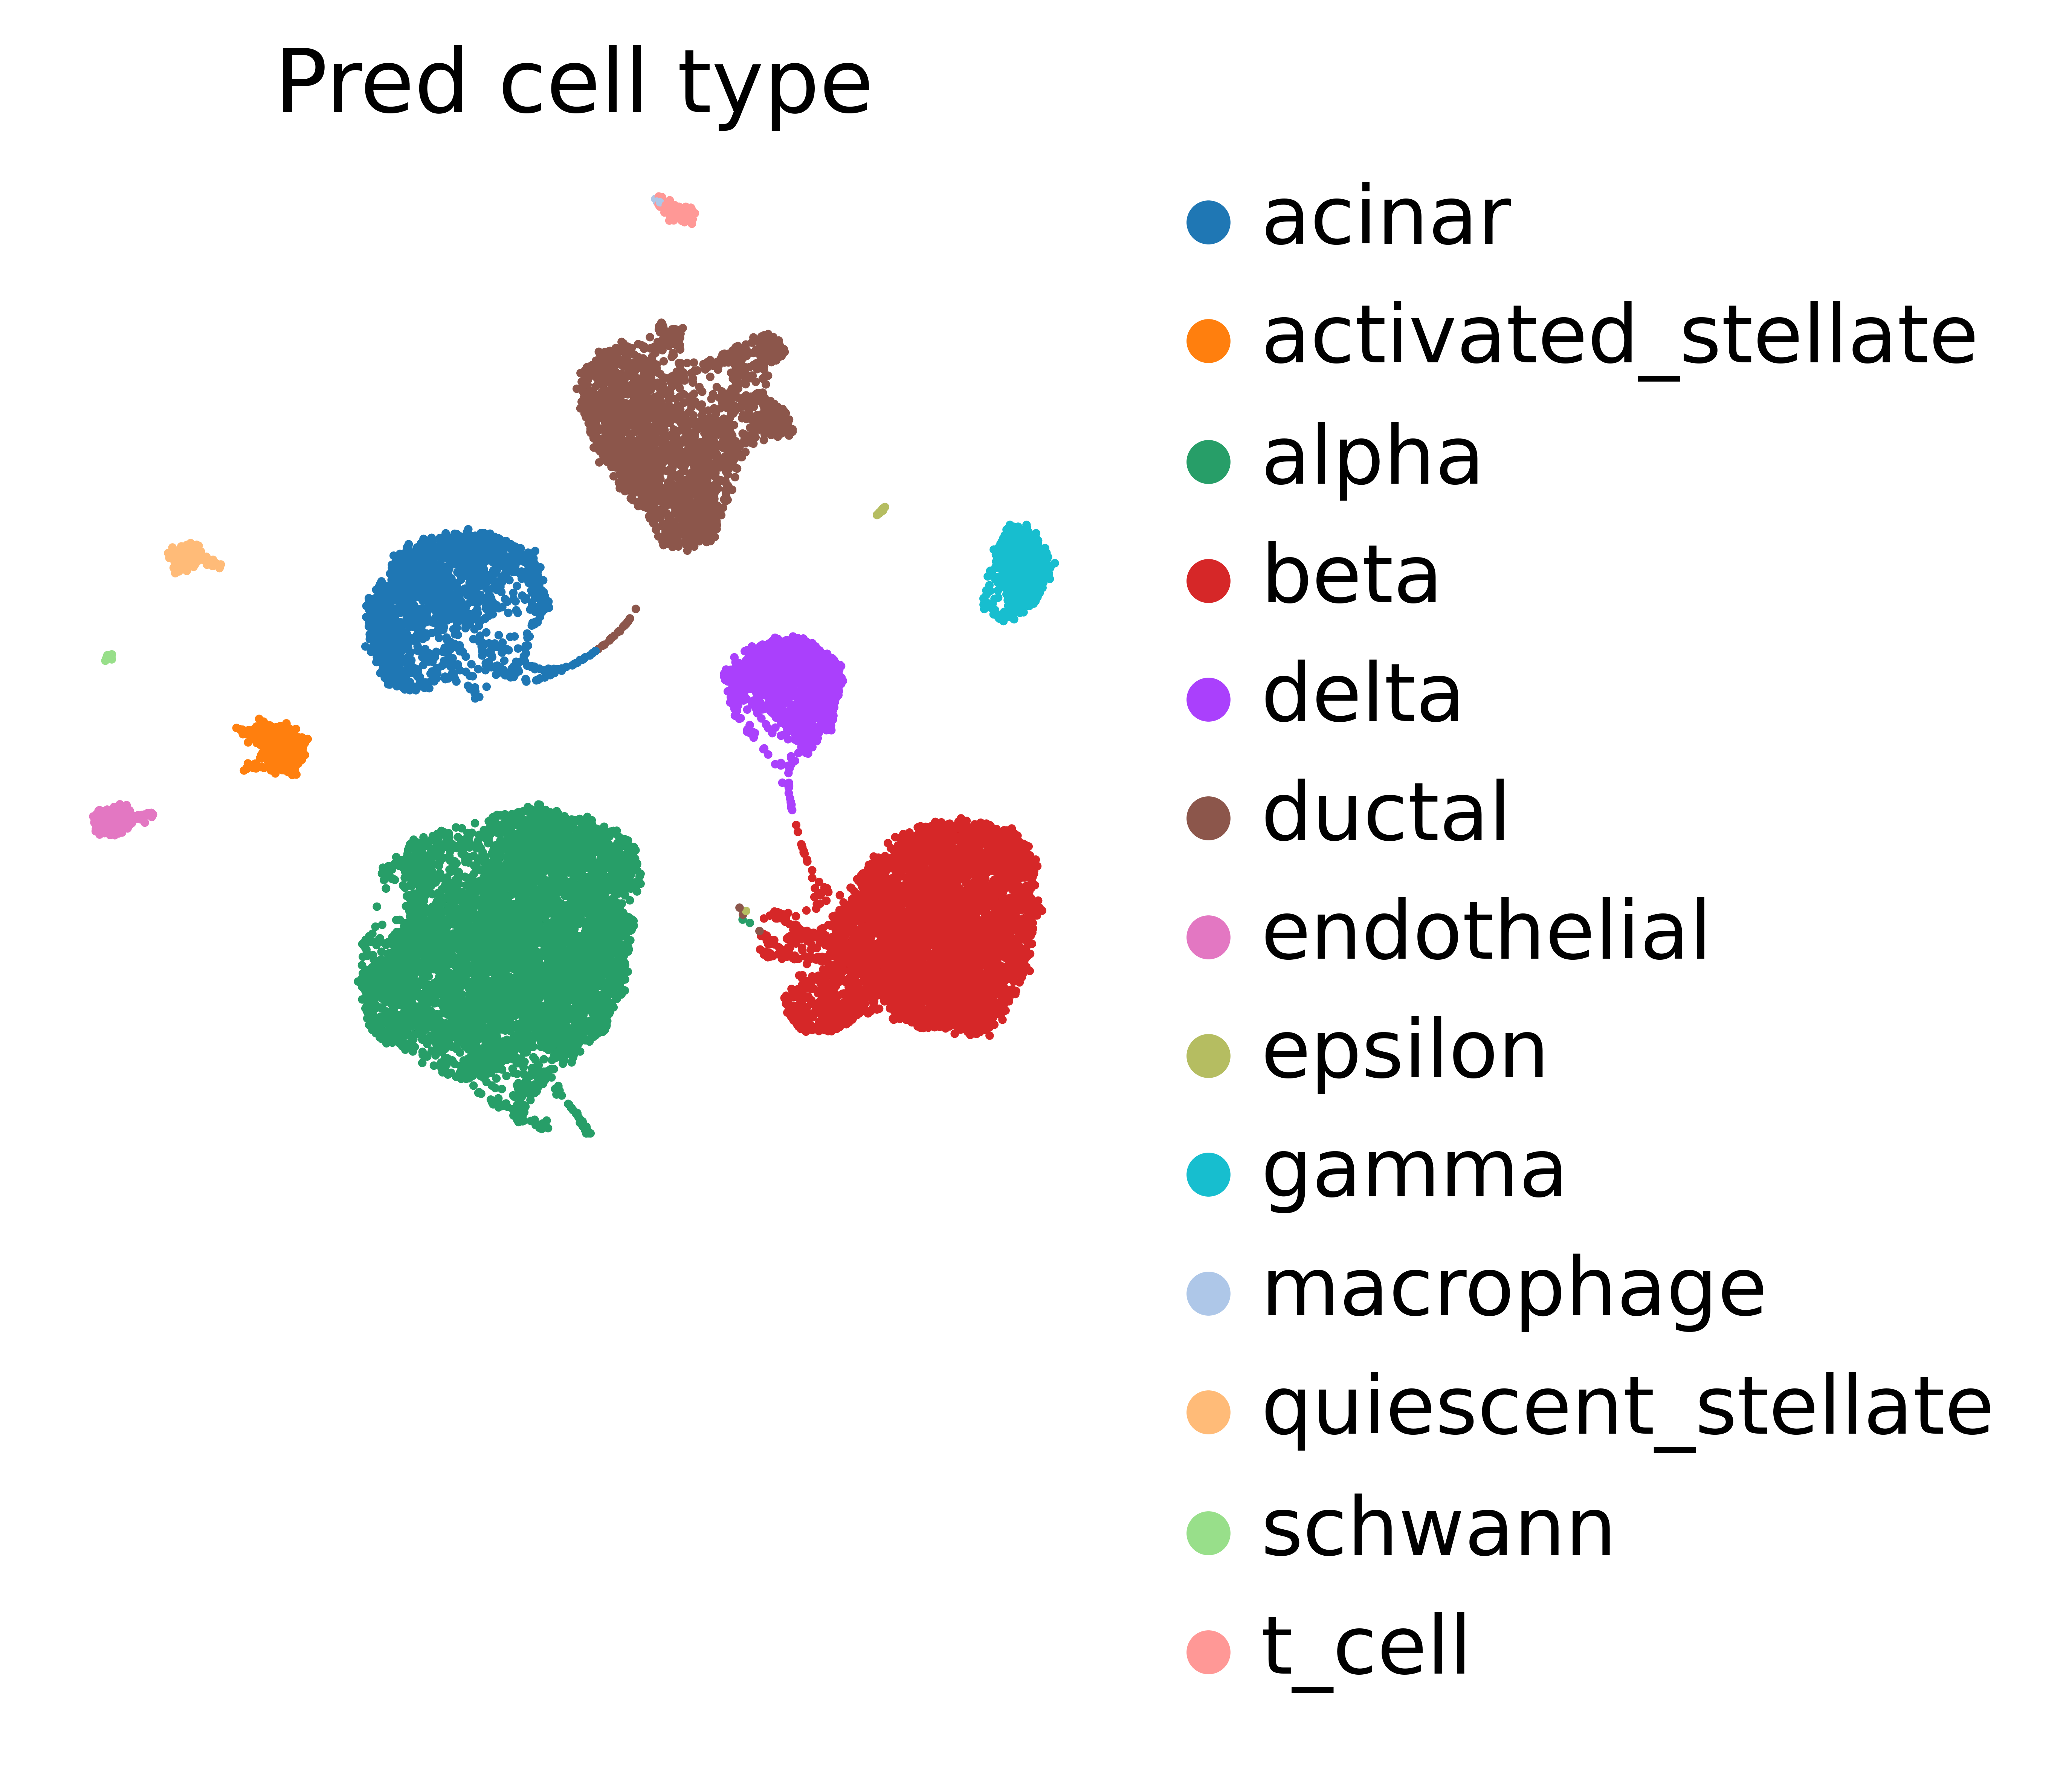

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sc.pl.umap(
    latent_adata,
    color='cell_type_pred',
    show=False,
    frameon=False,
    ax=ax
)
ax.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('Pred cell type')
fig.savefig('figure2/umap_wquery_celltype.png', dpi=500, bbox_inches='tight')

# Benchmarks

In [4]:
results_df = pd.read_pickle('./../benchmarks/benchmarks_new_fixed.pkl')

In [5]:
results_df['method'] = results_df['method'].astype('category')
results_df['method'] = results_df['method'].cat.rename_categories(
    {
        'embedcvae': 'LATAQ',
        'lataq_noland': 'LATAQ - land',
        'tranvae': 'trVAE + land',
        'scanvi': 'scanVI',
        'scvi': 'scVI',
        'mars': 'MARS',
        'svm': 'SVM',
        'seurat': 'Seurat',
        'symphony': 'Symphony'
    }
)

In [7]:
integration_methods = ['scanVI', 'scVI', 'Seurat', 'Symphony', 'trVAE + land', 'LATAQ', 'LATAQ - land']
classification_methods = ['scanVI', 'Seurat', 'SVM', 'MARS', 'trVAE + land', 'LATAQ']

In [8]:
results_df['integration_scores_mean'] = results_df[[
    'result.NMI_cluster/label',
    'result.ARI_cluster/label',
    'result.ASW_label',
    'result.ASW_label/batch',
    'result.PCR_batch',
    'result.isolated_label_F1',
    'result.isolated_label_silhouette',
    'result.graph_conn',
]].mean(axis=1)

In [9]:
results_melt = pd.melt(results_df, id_vars = ['config.data', 'method'])
results_melt = results_melt[~results_melt['variable'].str.contains('time')]
results_melt['method'] = results_melt['method'].astype('category')
results_melt['method'] = results_melt['method'].cat.reorder_categories(
    [
        'LATAQ',
        'LATAQ - land',
        'trVAE + land',
        'scVI',
        'scanVI',
        'MARS',
        'Seurat',
        'Symphony',
        'SVM'
    ]
)

In [10]:
results_melt

config.data    method                  variable     value
104    pancreas    scanVI  result.NMI_cluster/label  0.925007
105        pbmc    scanVI  result.NMI_cluster/label  0.886107
106       brain    scanVI  result.NMI_cluster/label  0.711047
107      scvelo    scanVI  result.NMI_cluster/label  0.612339
108       tumor    scanVI  result.NMI_cluster/label  0.474573
..          ...       ...                       ...       ...
671        pbmc  Symphony   integration_scores_mean  0.751475
672      scvelo  Symphony   integration_scores_mean  0.542324
673        lung  Symphony   integration_scores_mean  0.613099
674       tumor  Symphony   integration_scores_mean  0.546327
675       brain  Symphony   integration_scores_mean  0.657377

[572 rows x 4 columns]

In [11]:
results_melt.groupby(['method', 'variable']).mean()

value
method variable                                  
LATAQ  integration_scores_mean           0.705037
       result.ARI_cluster/label          0.651794
       result.ASW_label                  0.748229
       result.ASW_label/batch            0.750635
       result.NMI_cluster/label          0.781664
...                                           ...
SVM    result.f1-score-macro             0.732632
       result.f1-score-weighted          0.795340
       result.graph_conn                      NaN
       result.isolated_label_F1               NaN
       result.isolated_label_silhouette       NaN

[99 rows x 1 columns]

In [12]:
palette_dict = {
    'LATAQ': '#8E44AD',
    'LATAQ - land': '#BB8FCE',
    'trVAE + land': '#BB8FCE',
    'scVI': '#3498DB',
    'scanVI': '#85C1E9',
    'MARS': '#616A6B',
    'Seurat': '#CB4335',
    'Symphony': '#F1948A',
    'SVM': '#F7DC6F'
}

In [15]:
df_plot

NameError: name 'df_plot' is not defined

In [16]:
mean_df = df_plot.groupby('method').mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'avg'
mean_df.columns = ['method', 'value', 'config.data']
df_plot = df_plot.append(mean_df)
df_plot

NameError: name 'df_plot' is not defined

In [63]:
mean_df = df_plot.groupby('method').mean()

<ipython-input-17-013614d5ac62>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()


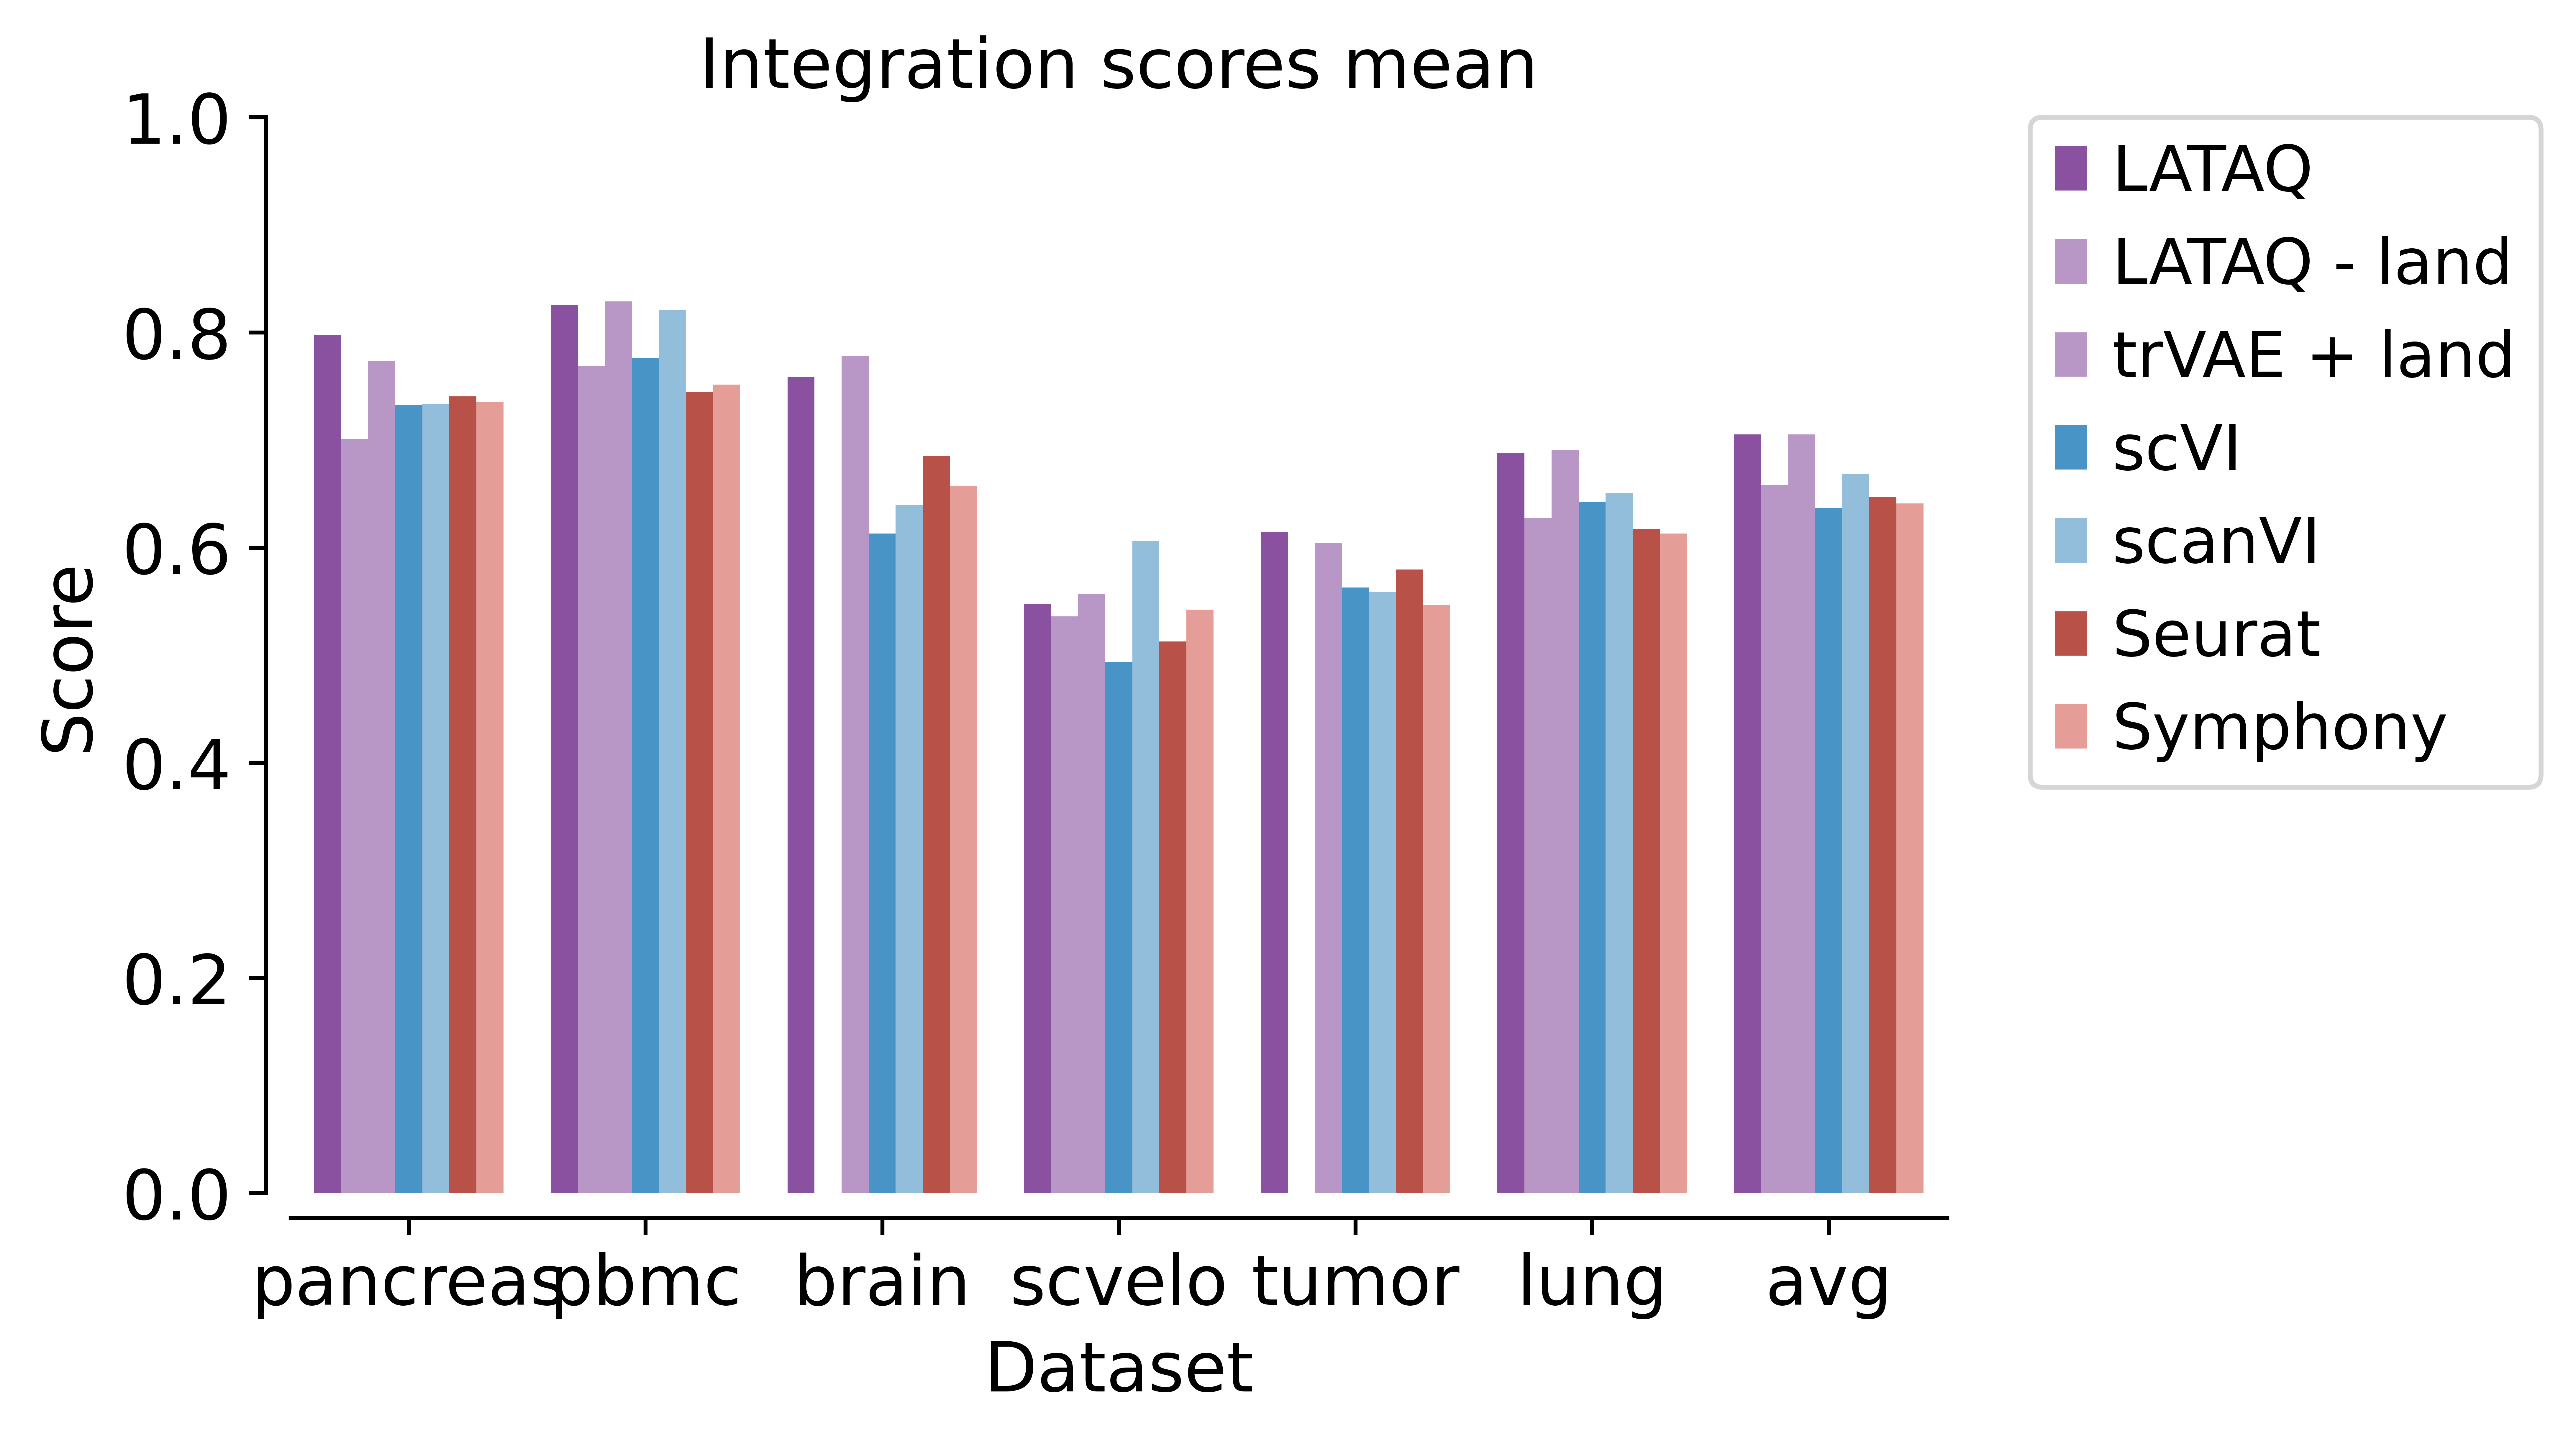

In [17]:
df_plot = results_melt[
    (results_melt['method'].isin(integration_methods))
    & (results_melt['variable'] == 'integration_scores_mean')
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby('method').mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'avg'
mean_df.columns = ['method', 'value', 'config.data']
df_plot = df_plot.append(mean_df)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.barplot(
    x='config.data',
    y='value',
    hue='method',
    data=df_plot,
    palette=palette_dict,
    ax=ax
)
ax.set_title('Integration scores mean')
ax.set_ylabel('Score')
ax.set_xlabel('Dataset')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylim([0, 1])
ax.grid('off')
ax.grid(b=None)
sns.despine(offset=5)
#fig.savefig('figure2/benchmark_integration.png', dpi=600, bbox_inches='tight')

<ipython-input-65-26a8f62ba660>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()


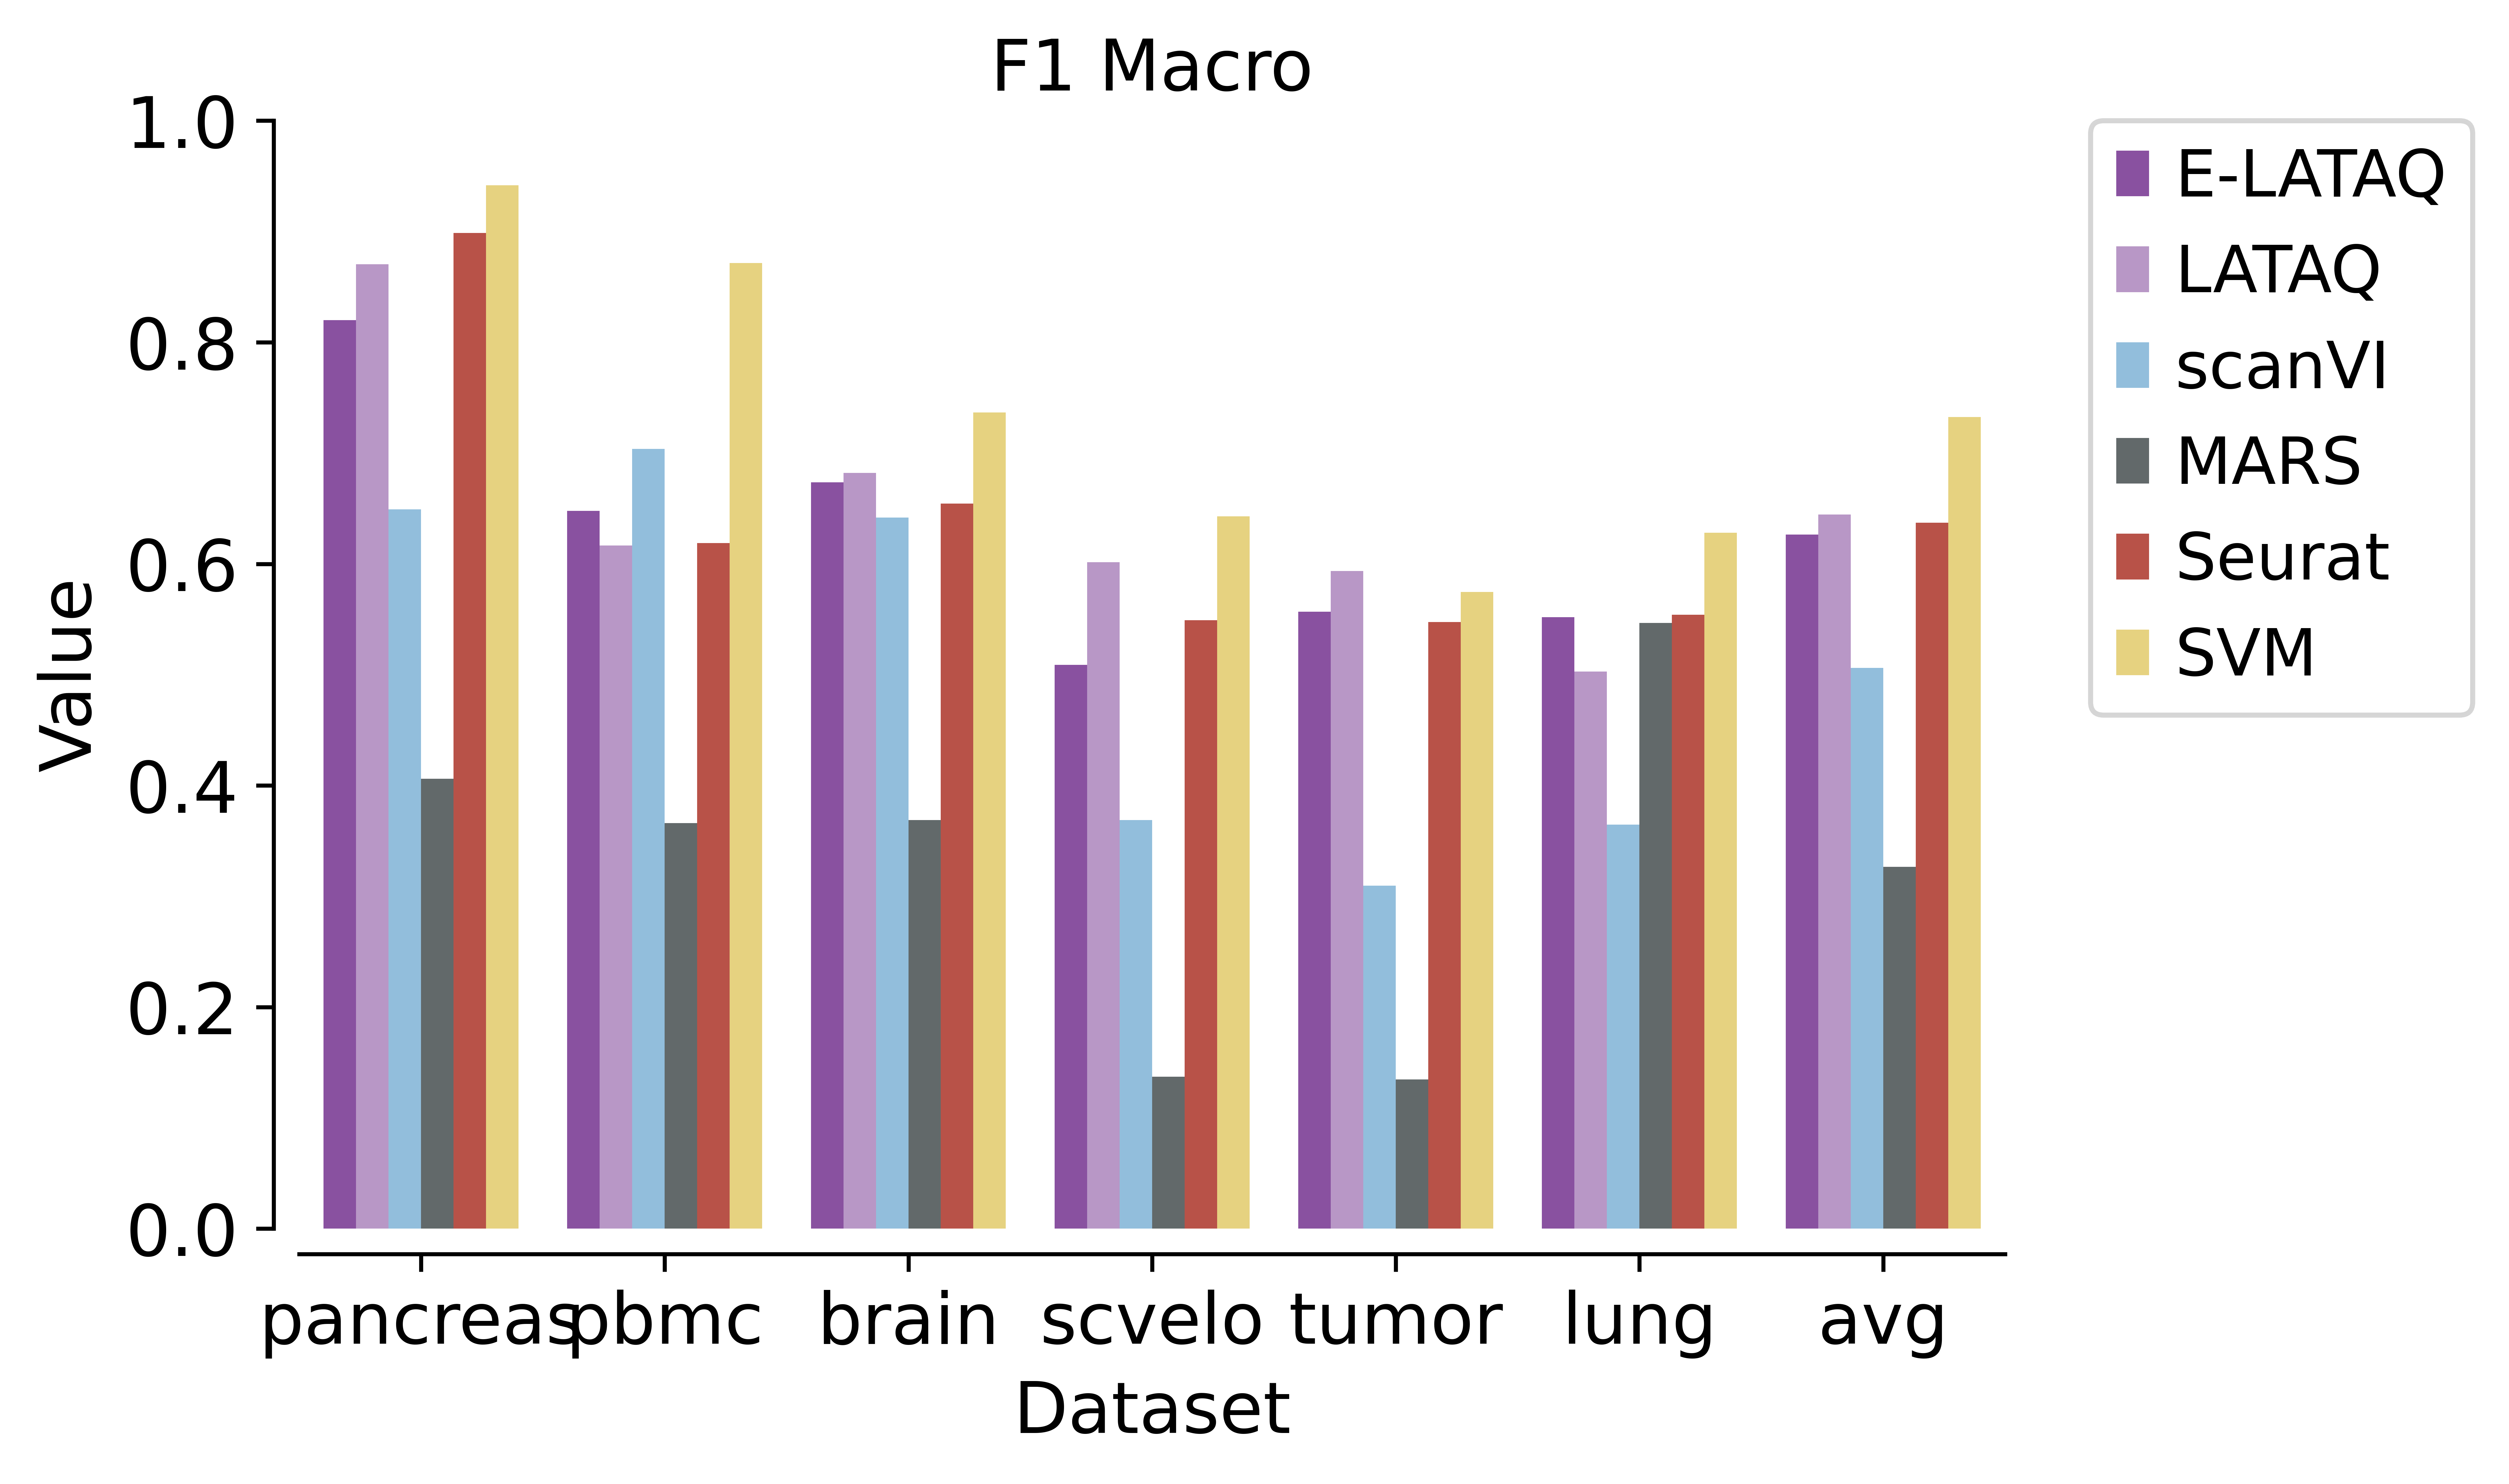

In [65]:
df_plot = results_melt[
    (results_melt['method'].isin(classification_methods))
    & (results_melt['variable'] == 'result.f1-score-macro')
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby('method').mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'avg'
mean_df.columns = ['method', 'value', 'config.data']
df_plot = df_plot.append(mean_df)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.barplot(
    x='config.data',
    y='value',
    hue='method',
    data=df_plot,
    palette=palette_dict,
    ax=ax
)
ax.set_title('F1 Macro')
ax.set_ylabel('Value')
ax.set_xlabel('Dataset')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylim([0, 1])
ax.grid('off')
ax.grid(b=None)
sns.despine(offset=5)
#fig.savefig('figure2/benchmark_f1macro.png', dpi=600, bbox_inches='tight')

<ipython-input-66-710e3e07b8cd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['method'] = df_plot['method'].cat.remove_unused_categories()


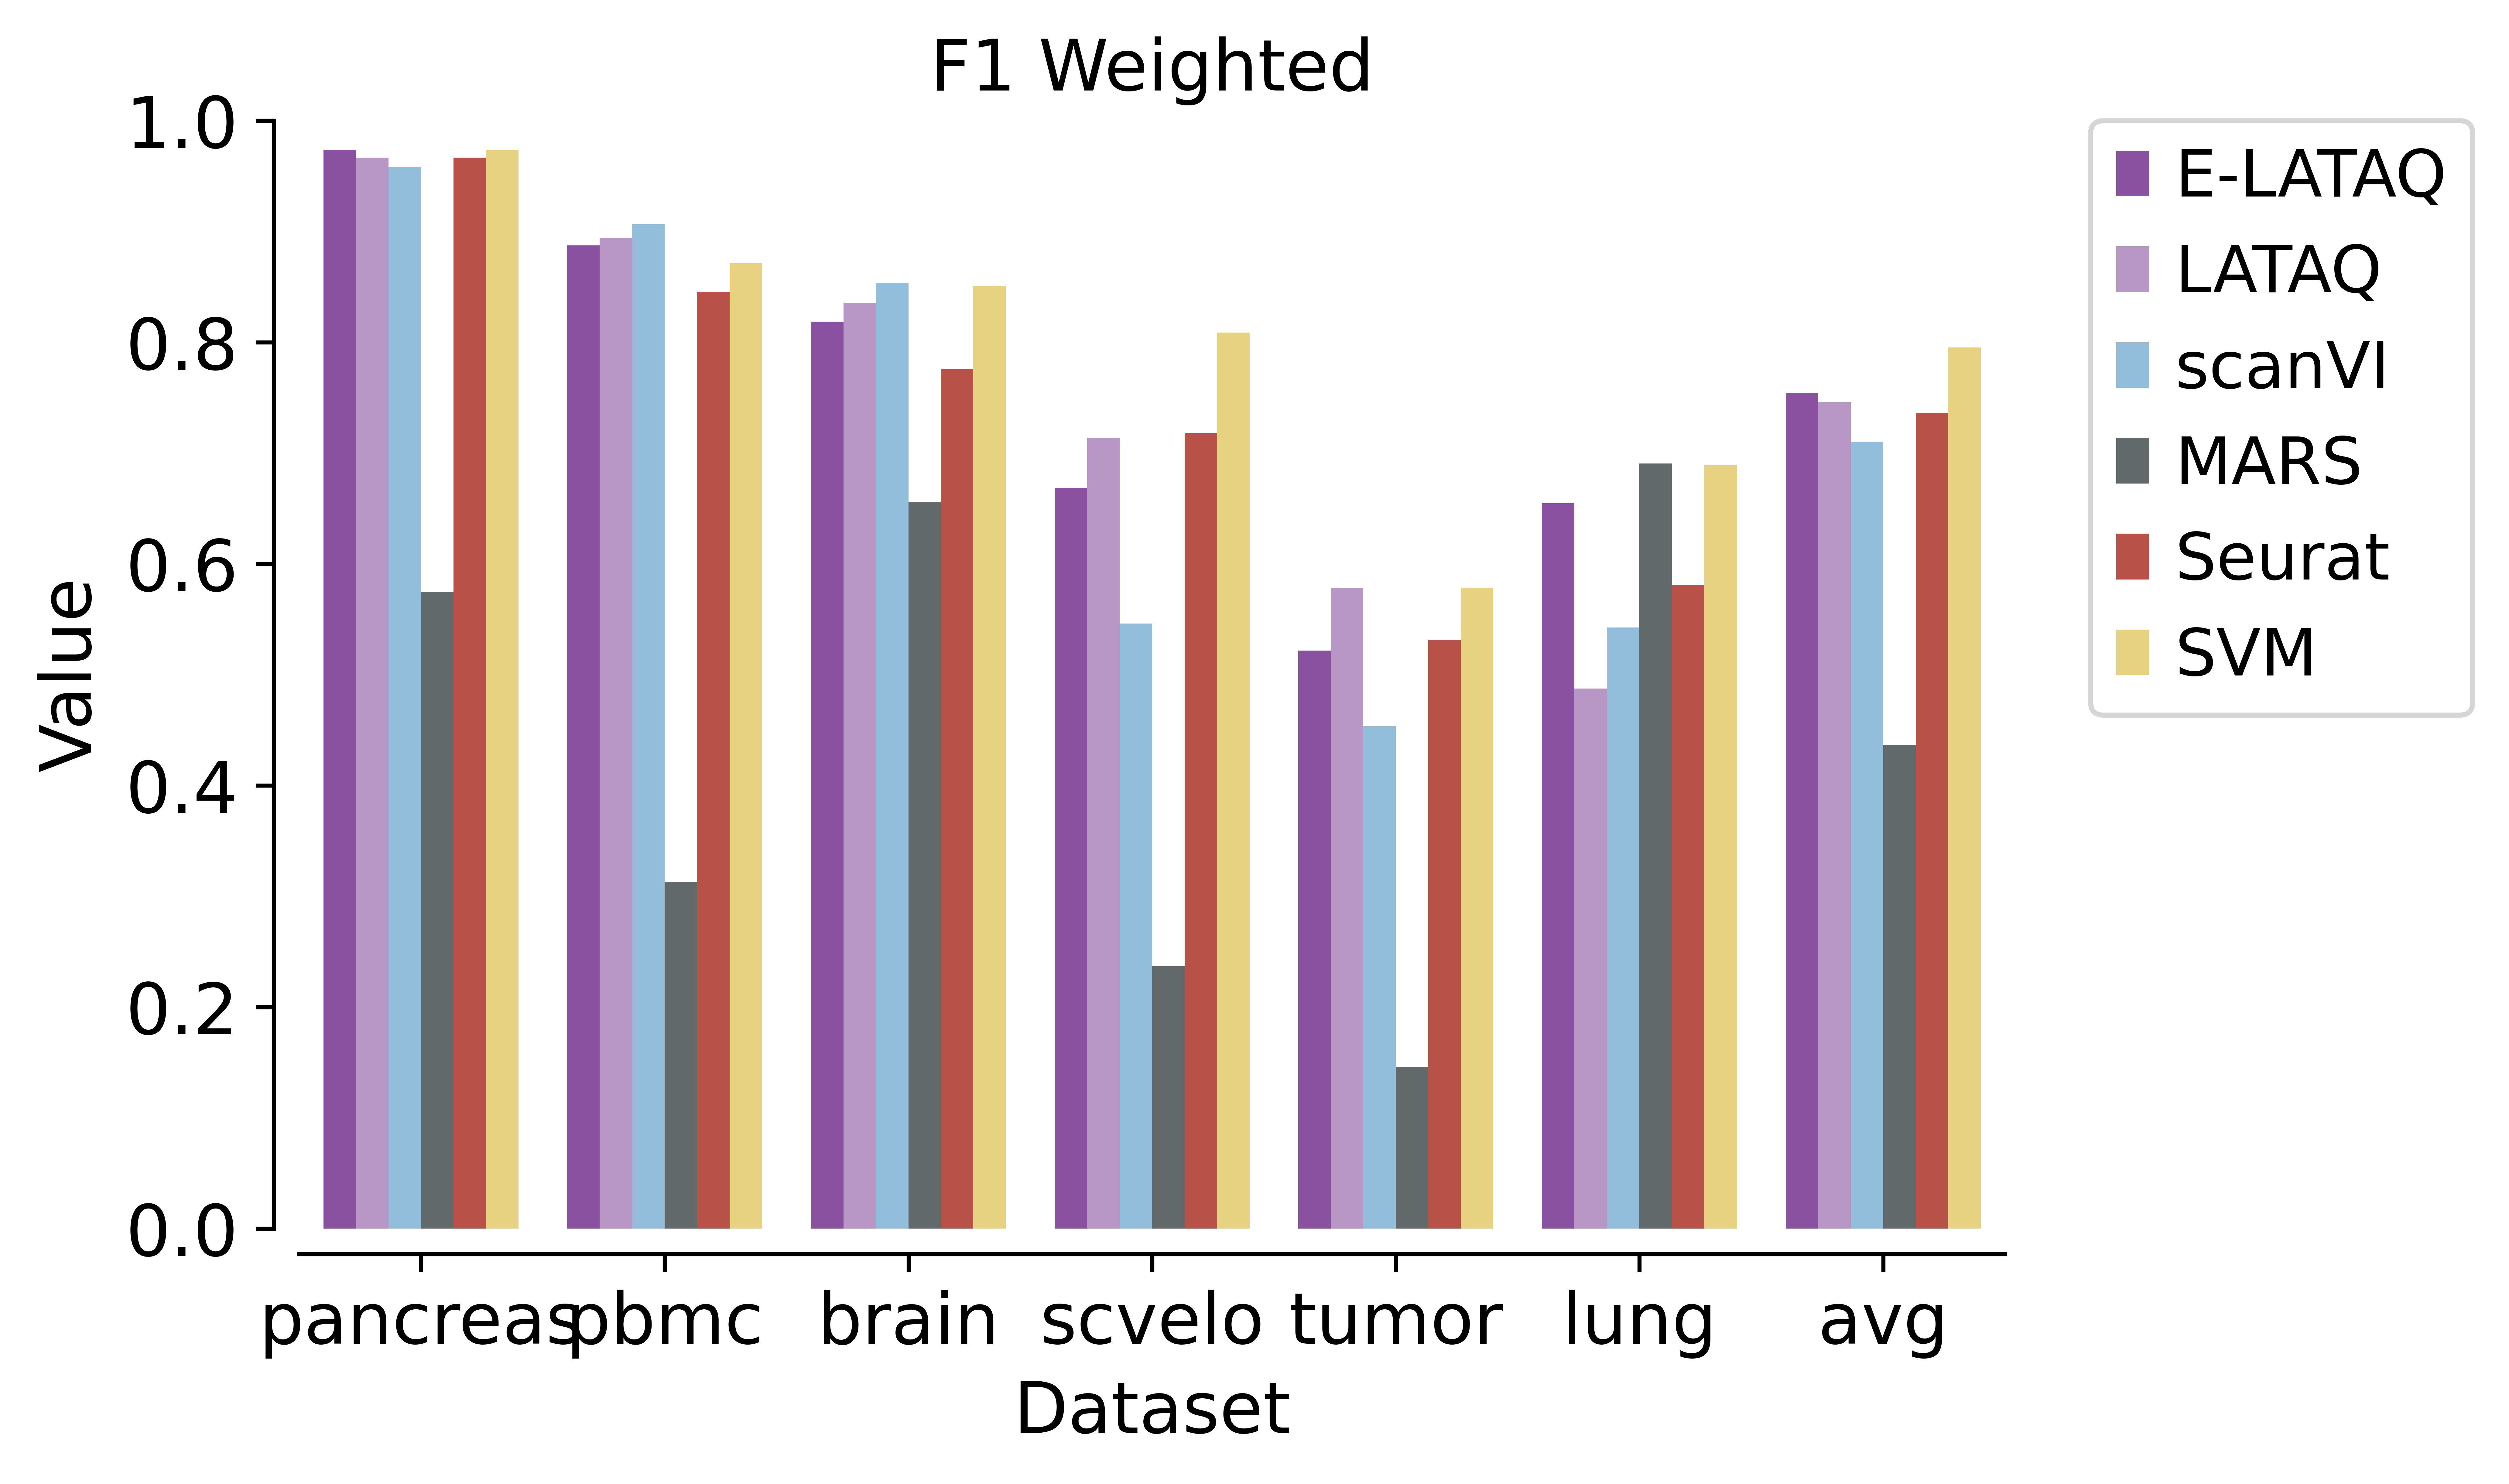

In [66]:
df_plot = results_melt[
    (results_melt['method'].isin(classification_methods))
    & (results_melt['variable'] == 'result.f1-score-weighted')
]
df_plot['method'] = df_plot['method'].cat.remove_unused_categories()

mean_df = df_plot.groupby('method').mean()
mean_df = mean_df.reset_index()
mean_df['index'] = 'avg'
mean_df.columns = ['method', 'value', 'config.data']
df_plot = df_plot.append(mean_df)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.barplot(
    x='config.data',
    y='value',
    hue='method',
    data=df_plot,
    palette=palette_dict,
    ax=ax
)
ax.set_title('F1 Weighted')
ax.set_ylabel('Value')
ax.set_xlabel('Dataset')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylim([0, 1])
ax.grid('off')
ax.grid(b=None)
sns.despine(offset=5)
#fig.savefig('figure2/benchmark_f1weighted.png', dpi=600, bbox_inches='tight')

In [67]:
df_plot = results_melt.pivot(index=['config.data', 'method'], values='value', columns='variable').reset_index()
df_plot = df_plot[df_plot['method'].isin(['E-LATAQ', 'LATAQ','scanVI', 'Seurat'])]
df_plot['method'] = df_plot['method'].astype('category').cat.remove_unused_categories()
df_mean = df_plot.groupby('method').mean()
df_std = df_plot.groupby('method').std()
df_bottom = df_plot.groupby('method').quantile(0.05)
df_bottom = df_mean - df_bottom
df_top = df_plot.groupby('method').quantile(0.95)
df_top = df_top - df_mean

In [68]:
df_mean

variable  integration_scores_mean  result.ARI_cluster/label  result.ASW_label  \
method                                                                          
E-LATAQ                  0.705037                  0.651794          0.748229   
LATAQ                    0.705225                  0.690841          0.717192   
scanVI                   0.668134                  0.633449          0.589538   
Seurat                   0.646691                  0.592544          0.565028   

variable  result.ASW_label/batch  result.NMI_cluster/label  result.PCR_batch  \
method                                                                         
E-LATAQ                 0.750635                  0.781664          0.350445   
LATAQ                   0.788221                  0.795590          0.345991   
scanVI                  0.843314                  0.731906          0.253095   
Seurat                  0.865436                  0.689035          0.286913   

variable  result.f1-score-macro  result.f1-score-weighted  result.graph_conn  \
method                                                                         
E-LATAQ                0.626485                  0.754200           0.966427   
LATAQ                  0.644540                  0.745917           0.959843   
scanVI                 0.506257                  0.710112           0.966959   
Seurat                 0.637115                  0.736303           0.972280   

variable  result.isolated_label_F1  result.isolated_label_silhouette  
method                                                                
E-LATAQ                   0.715536                          0.675567  
LATAQ                     0.661804                          0.682315  
scanVI                    0.732638                          0.594172  
Seurat                    0.599296                          0.602999

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


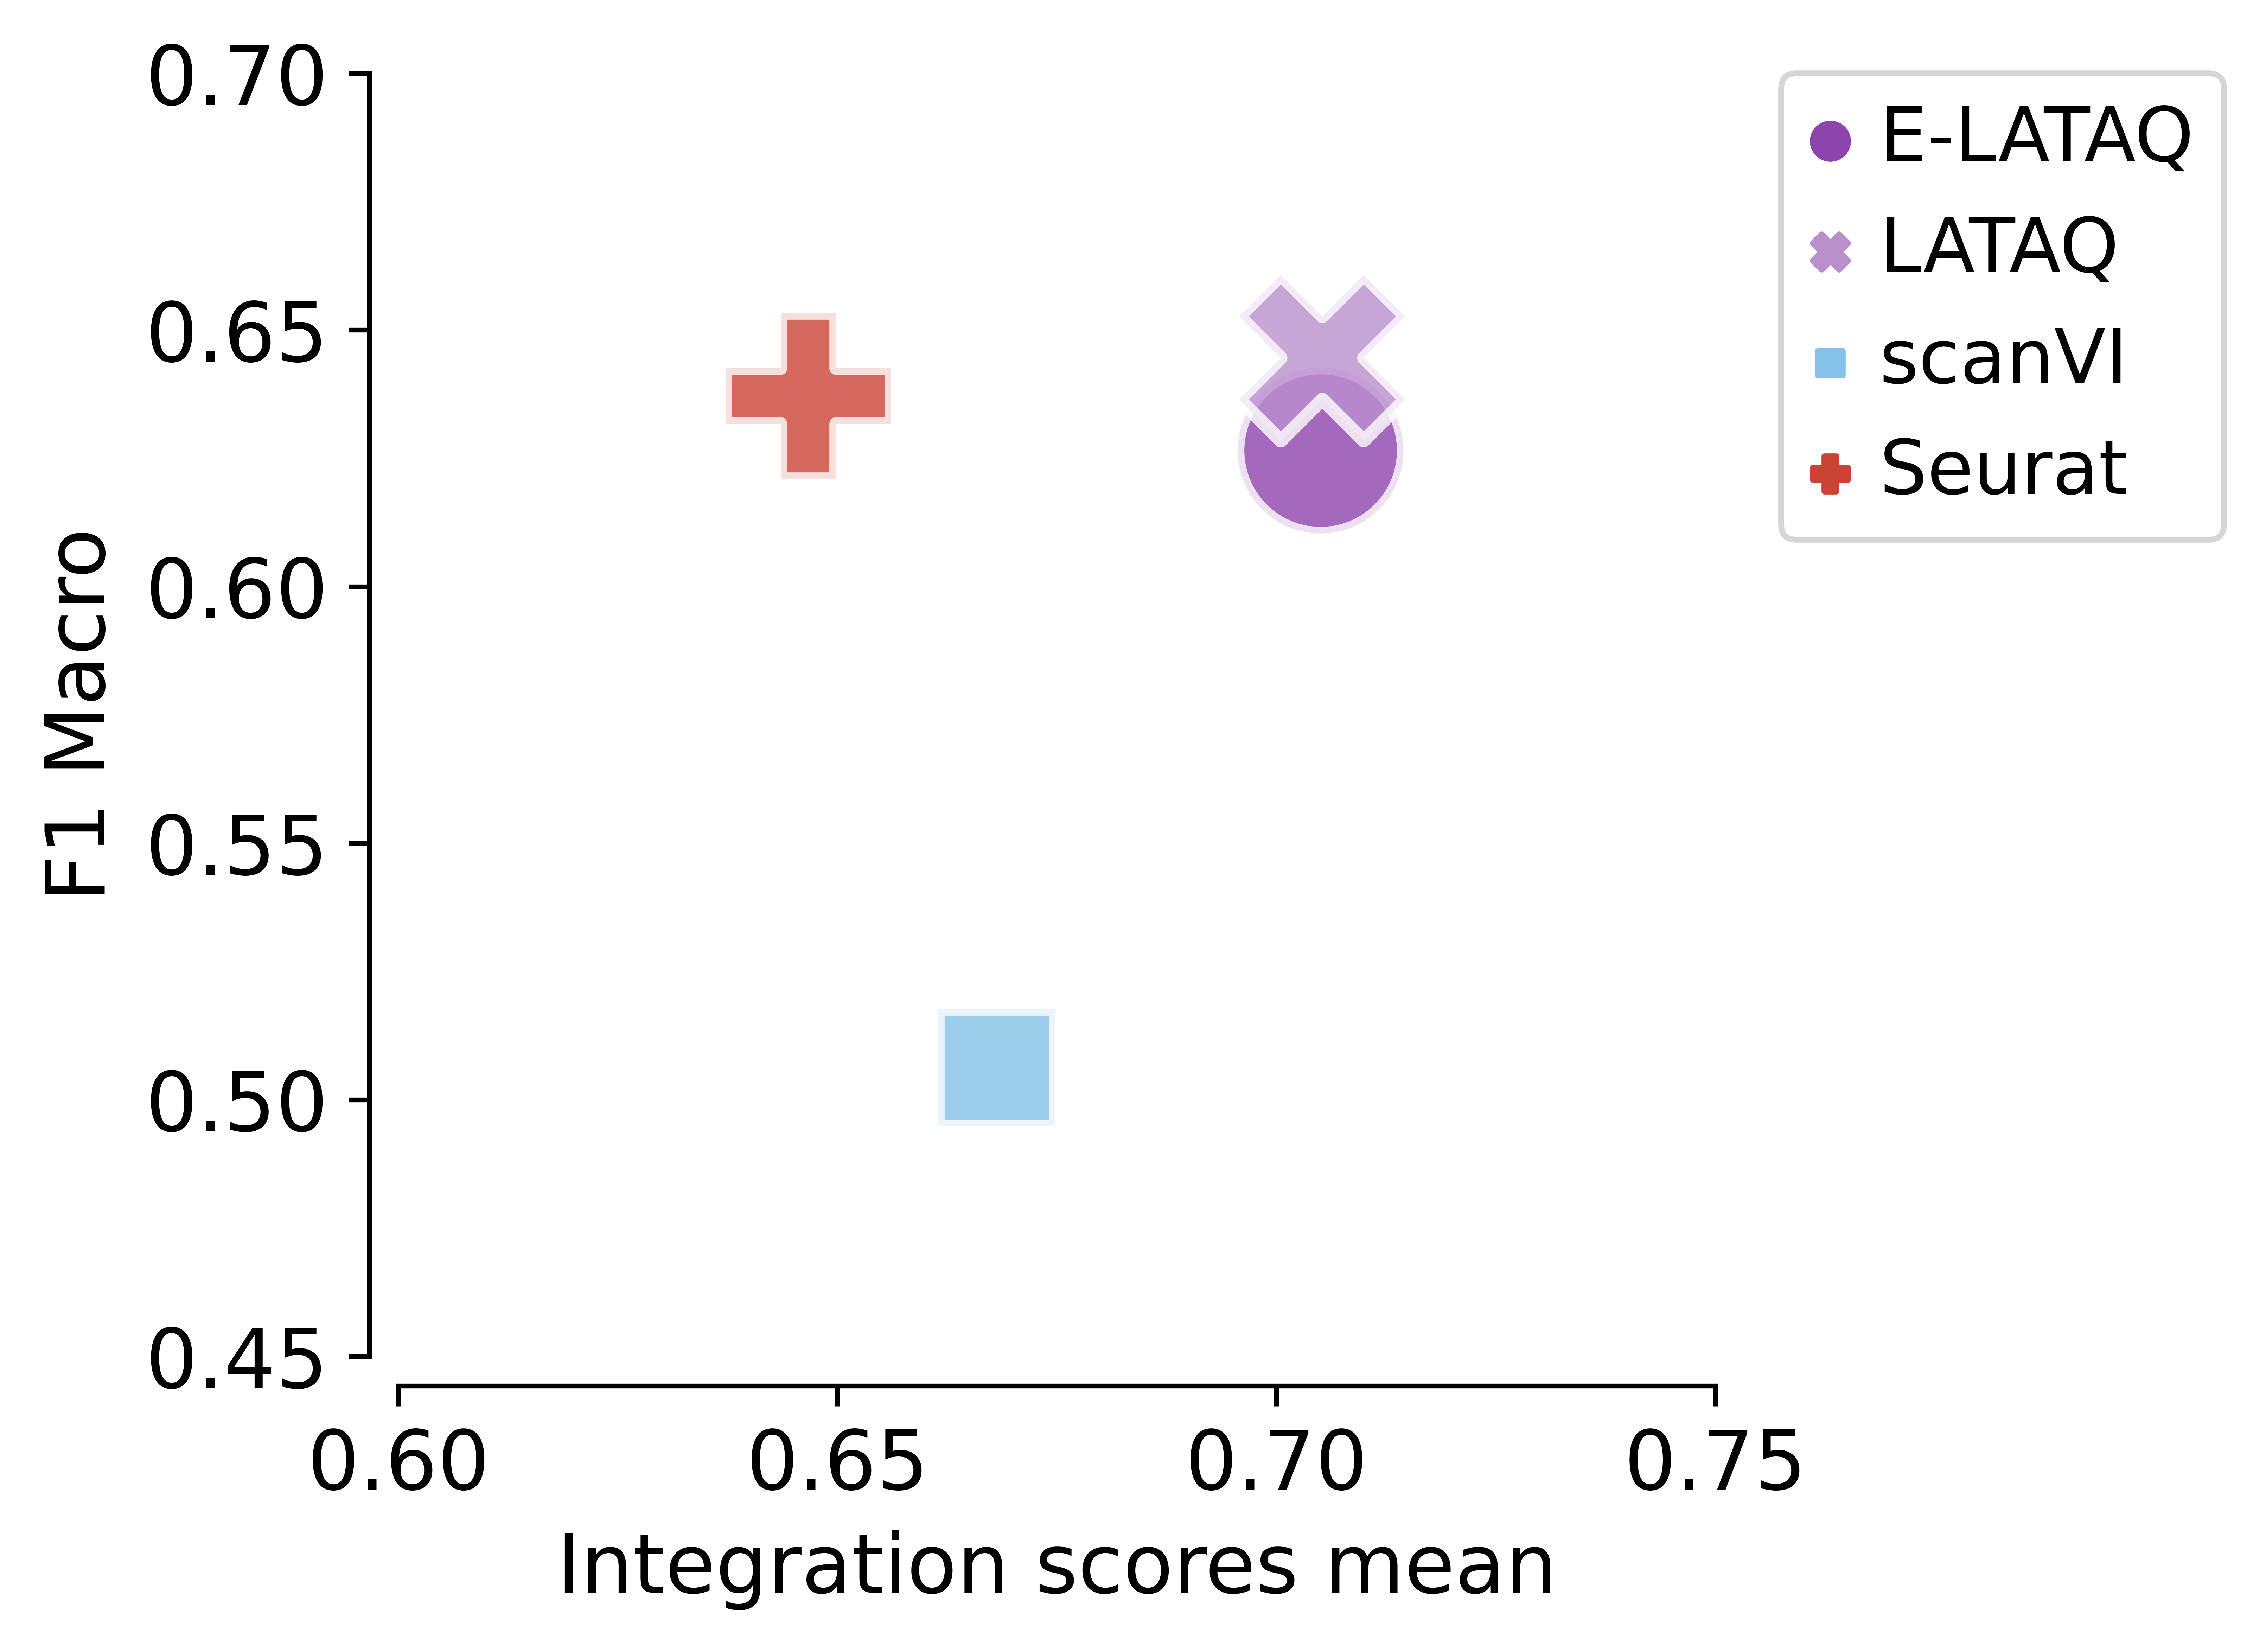

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(
    df_mean['integration_scores_mean'],
    df_mean['result.f1-score-macro'],
    hue=df_mean.index,
    style=df_mean.index,
    palette=palette_dict,
    ax=ax,
    s=800,
    alpha=0.8,
)
ax.set_ylabel('F1 Macro')
ax.set_xlabel('Integration scores mean')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlim([0.6, 0.75])
ax.set_ylim([0.45, 0.7])
ax.grid('off')
ax.grid(b=None)
sns.despine(offset=5)
#fig.savefig('figure2/benchmark_comparison_f1macro.png', dpi=600, bbox_inches='tight')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


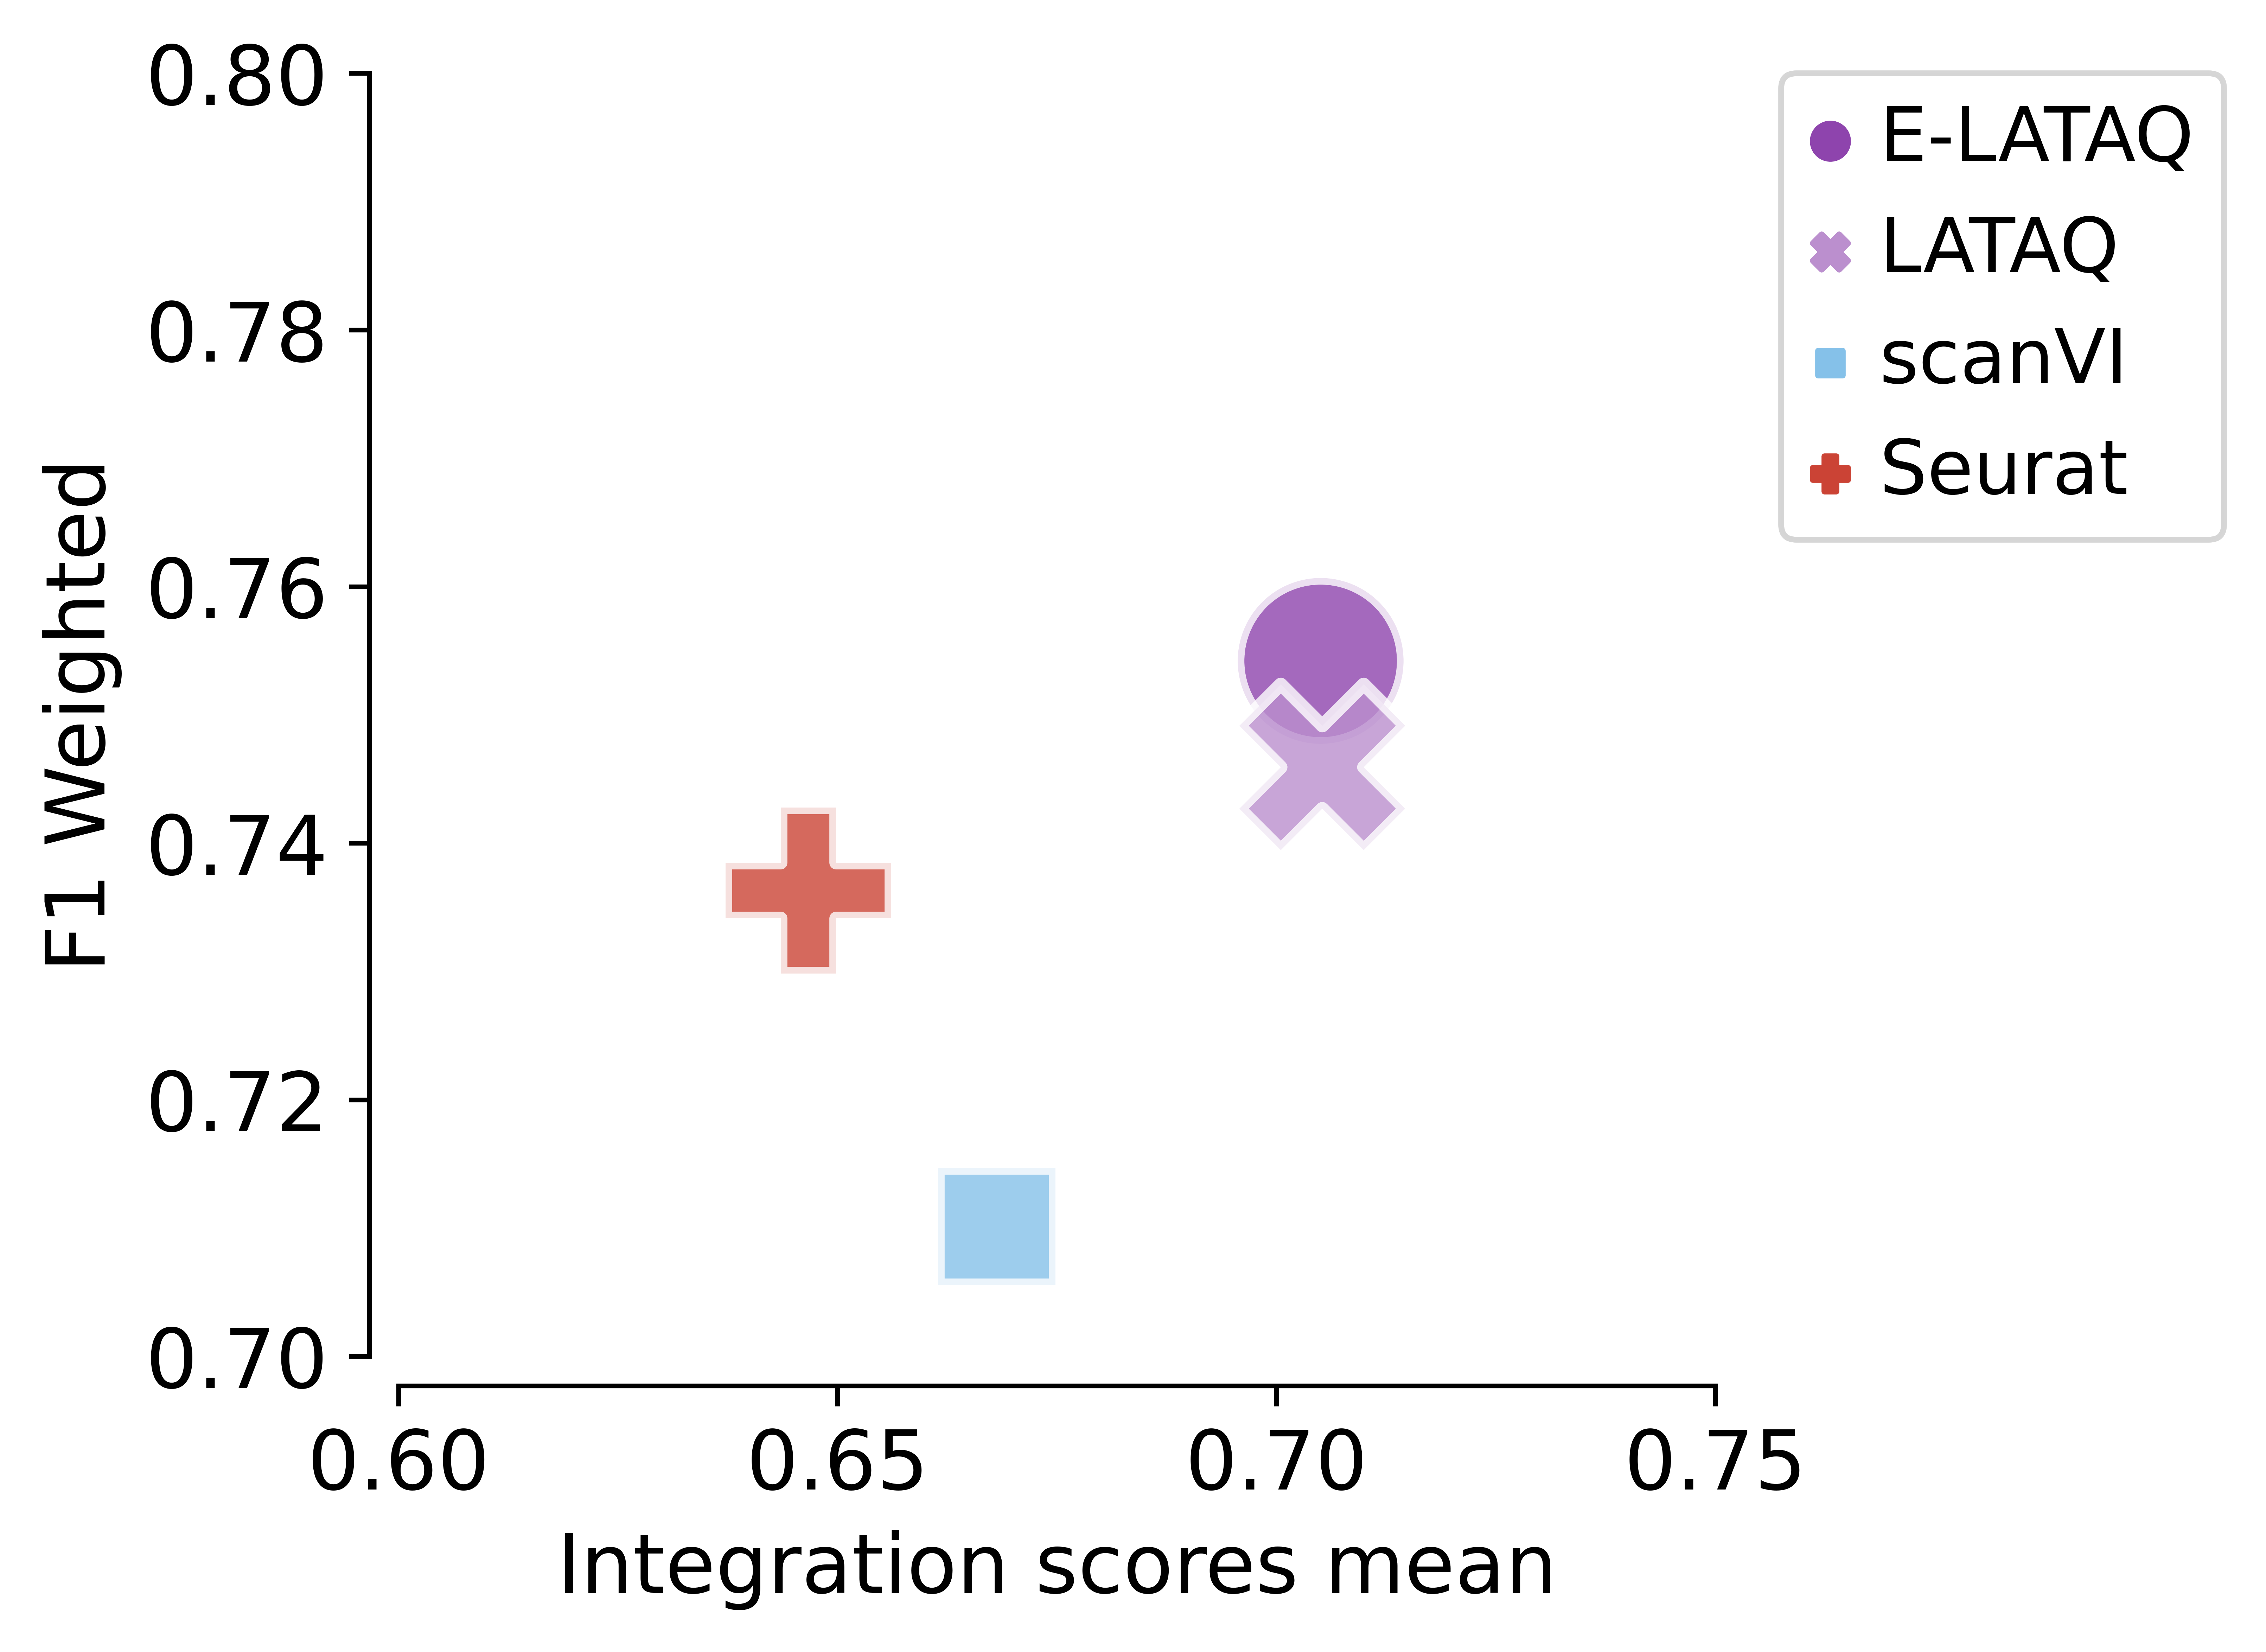

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(
    df_mean['integration_scores_mean'],
    df_mean['result.f1-score-weighted'],
    hue=df_mean.index,
    style=df_mean.index,
    palette=palette_dict,
    ax=ax,
    s=800,
    alpha=0.8,
)
ax.set_ylabel('F1 Weighted')
ax.set_xlabel('Integration scores mean')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlim([0.6, 0.75])
ax.set_ylim([0.7, 0.8])
ax.grid('off')
ax.grid(b=None)
sns.despine(offset=5)
#fig.savefig('figure2/benchmark_comparison_f1weighted.png', dpi=600, bbox_inches='tight')